In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import operator
import pickle
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In [1]:
from plotting_functions import *
# import functions plot_with_predict and plot_residuals

In [2]:
# bring in imdb data
df_imdb = pd.read_pickle('pickles/df_imdb_clean.pkl')

In [6]:
# bring in book data
df_bookdata = pd.read_pickle('pickles/df_bookdata.pkl')

In [7]:
# combine above datasets
df_full = df_imdb.merge(df_bookdata,left_on = ['title_imdb'],right_on = ['title'])

In [8]:
# create year_gap representing the years between book publication and film release
df_full['year'] = df_full['year'].astype(int);
df_full['year_gap'] = (df_full['year']-df_full['published'])

In [9]:
df_full[df_full['year_gap']<0]

,title_x,title_imdb,year,user_rating,runtime,avg_dir_gross,family,war,thriller,mystery,...,dir_accomplished,market_share,mpaa_pg,mpaa_pg13,mpaa_r,title_y,rating,reviewers,published,year_gap


In [10]:
df_full.drop(columns=['title_x','title_imdb','title_y','year','published'],inplace=True)
df_full.rename(columns={'rating':'book_rating'},inplace=True)
df_full.head()

,user_rating,runtime,avg_dir_gross,family,war,thriller,mystery,western,adventure,crime,...,animation,scifi,dir_accomplished,market_share,mpaa_pg,mpaa_pg13,mpaa_r,book_rating,reviewers,year_gap
0,6.8,104.0,1.448492e+08,False,False,False,False,False,False,False,...,False,False,True,0.0,0,1,0,3.77,23753,12
1,6.4,86.0,3.435399e+08,False,False,False,False,False,True,False,...,True,False,True,15.0,1,0,0,4.35,236154,41
2,7.2,142.0,1.877139e+08,False,False,True,False,False,True,False,...,False,True,True,8.0,0,1,0,4.34,5309089,4
3,6.5,101.0,3.749393e+07,False,False,False,False,False,False,False,...,False,False,True,18.4,0,1,0,4.11,294867,4
4,5.9,105.0,4.926056e+07,False,False,False,False,False,False,False,...,False,False,True,0.0,0,0,1,3.70,121711,2


In [11]:
df_full.columns

Index(['user_rating', 'runtime', 'avg_dir_gross', 'family', 'war', 'thriller',
       'mystery', 'western', 'adventure', 'crime', 'drama', 'comedy',
       'romance', 'fantasy', 'horror', 'history', 'action', 'musical',
       'animation', 'scifi', 'dir_accomplished', 'market_share', 'mpaa_pg',
       'mpaa_pg13', 'mpaa_r', 'book_rating', 'reviewers', 'year_gap'],
      dtype='object')

In [12]:
movies = df_full.select_dtypes(exclude=['object'])

In [131]:
X = movies[[x for x in movies.columns if x != 'user_rating']] 
y = movies['user_rating']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [133]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

In [134]:
# pickle everything!
pickle.dump(X_train, open("pickles/X_train.pkl",'wb'))
pickle.dump(X_test, open('pickles/X_test.pkl', 'wb'))
pickle.dump(y_train, open('pickles/y_train.pkl', 'wb'))
pickle.dump(y_test, open('pickles/y_test.pkl', 'wb'))
pickle.dump(df_train, open('pickles/df_train.pkl', 'wb'))
pickle.dump(df_test, open('pickles/df_test.pkl', 'wb'))

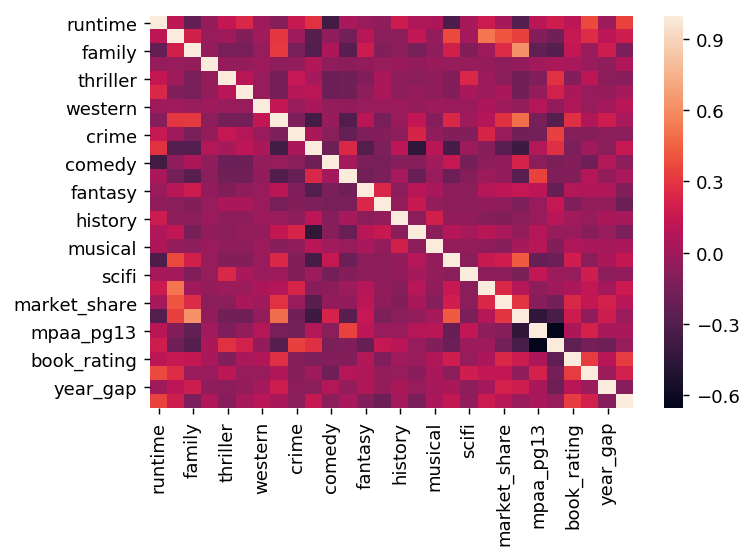

In [248]:
# quick look at correlations heatmap
plt.figure(dpi=130)
sns.heatmap(df_train.corr())

From the correlation heatmap, it seems dir_accomplished and avg_dir_gross have a higher correlation which is expected since one was created from the other. In addition, mpaa_pg and family have a higher correlation value which is also not unexpected since family films are generally rated PG.

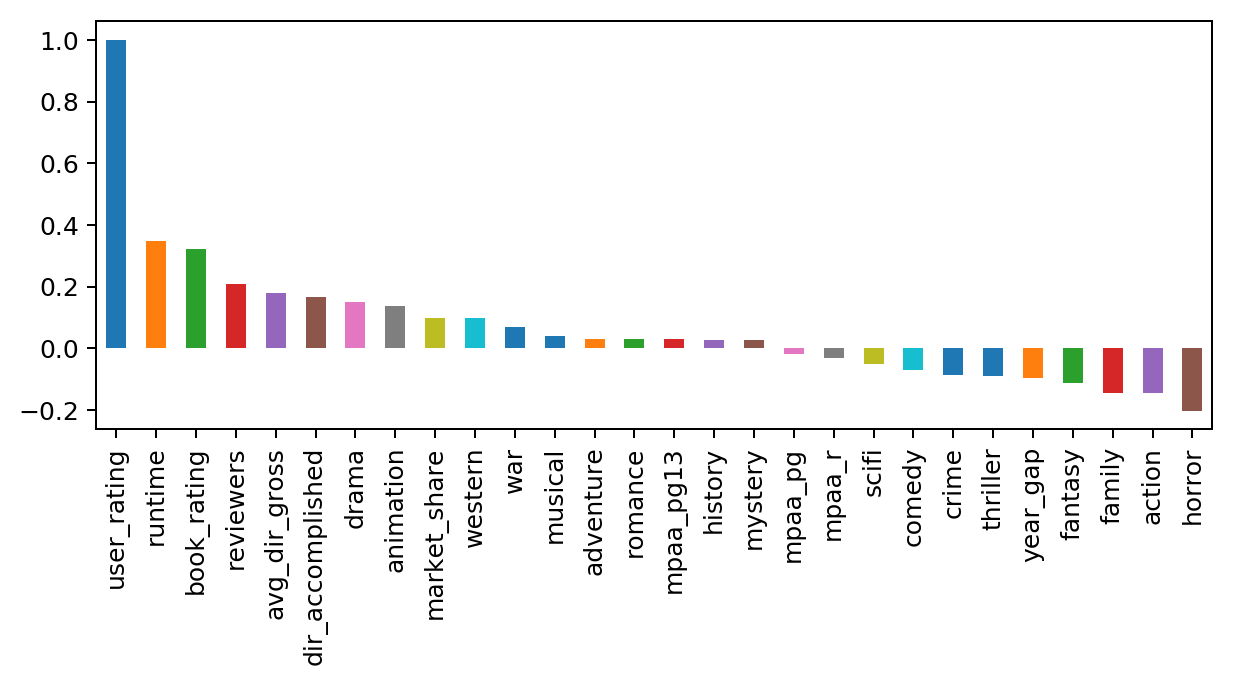

In [18]:
# Get the correlations with 'user_rating' sorted in descending order
plt.figure(figsize = (8,3),dpi=180)
df_train.corr()['user_rating'].sort_values(ascending=False).plot(kind='bar')

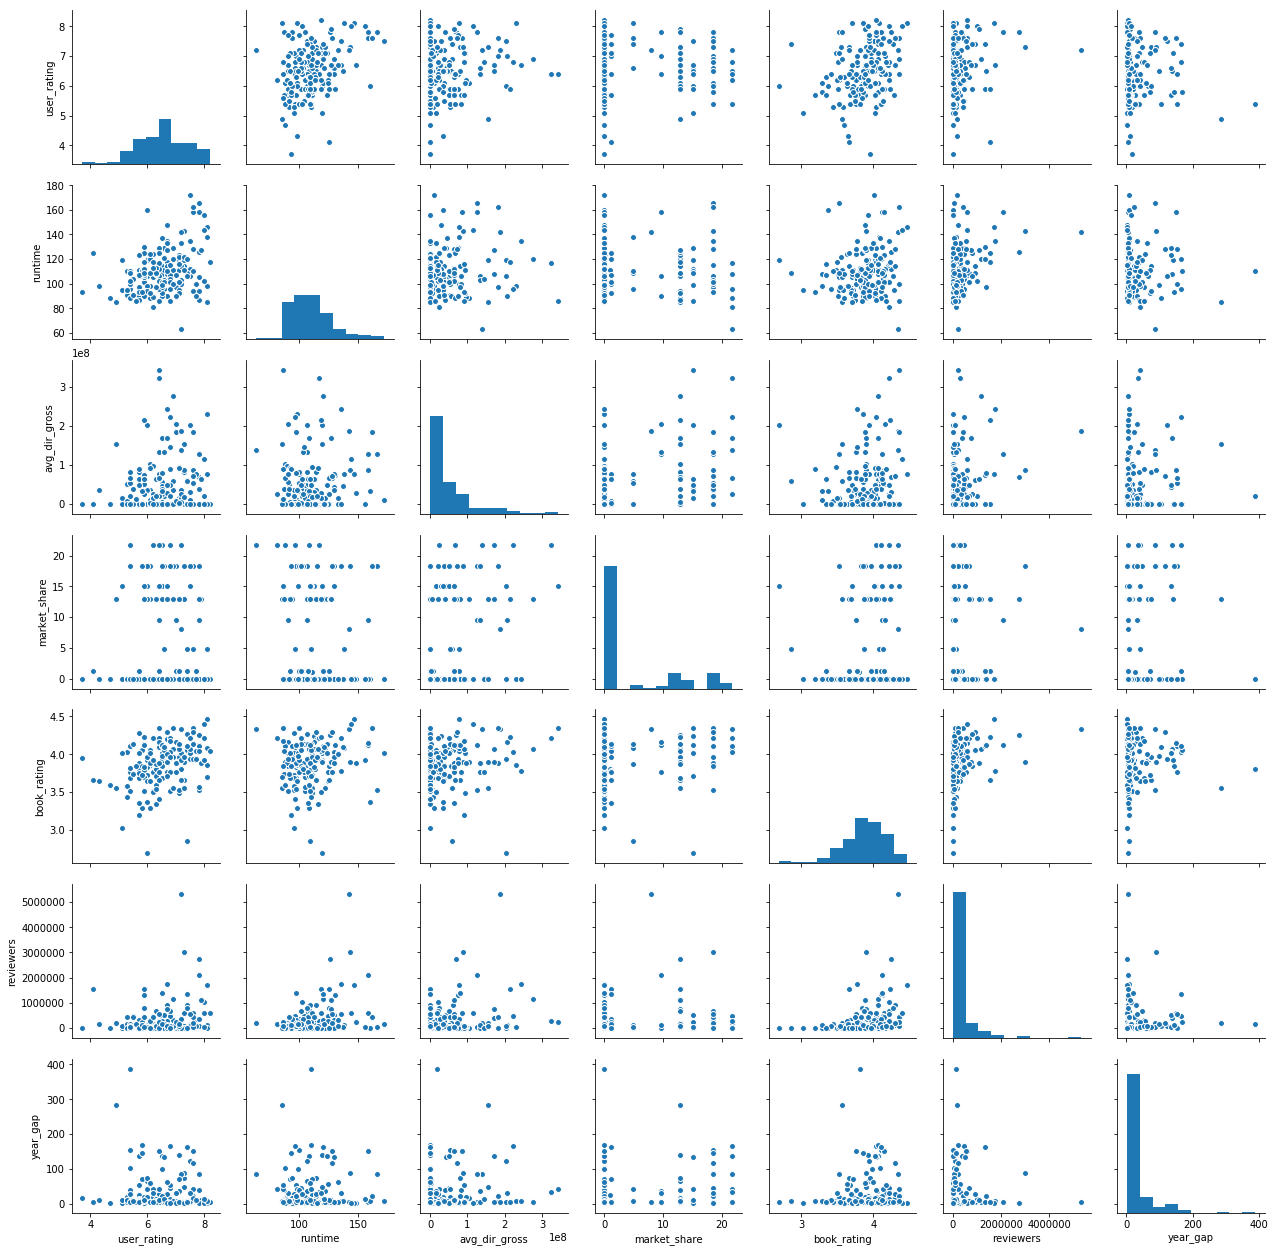

In [19]:
sns.pairplot(df_train[['user_rating','runtime','avg_dir_gross',
                       'market_share','book_rating','reviewers','year_gap']])

Based on the pairplot for the included features, it appears that collinearity will not be a major concern. However, let's take a closer look at the histograms. Since some of the histograms have skewed distributions, those features need to be log transformed (avg_dir_gross, market_share, reviewers, year_gap) to be used in a linear regression model.

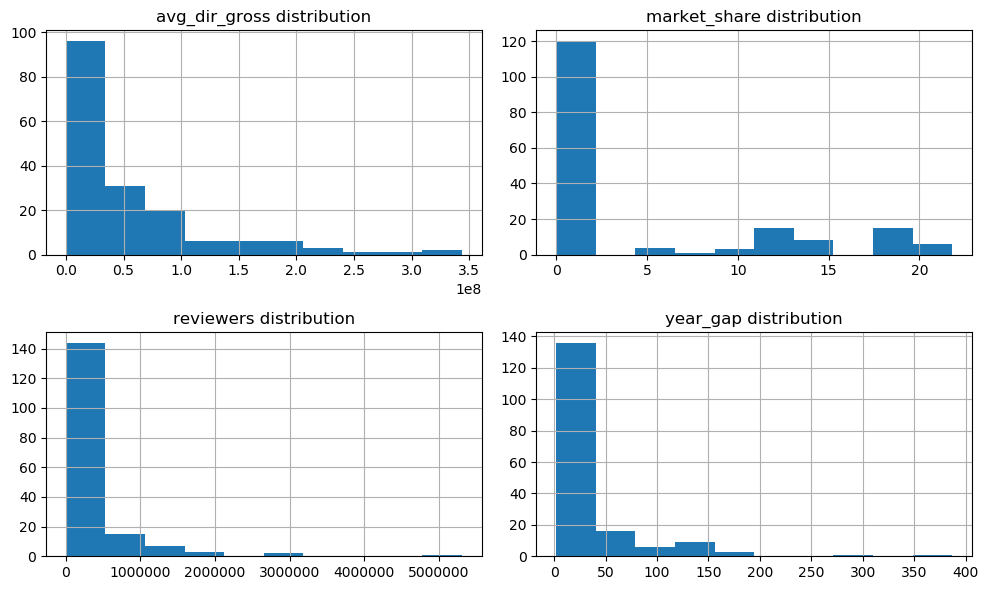

In [20]:
# a literal closer look at the histograms
var_list = ['avg_dir_gross','market_share','reviewers','year_gap']
fig=plt.figure(figsize=(10,6),dpi=100)
for i, var in enumerate(var_list):
    ax=fig.add_subplot(2,2,i+1)
    df_train[var].hist(ax=ax)
    ax.set_title(var+" distribution")
fig.tight_layout()

Text(0.5,1,'Distribution of Film Ratings')

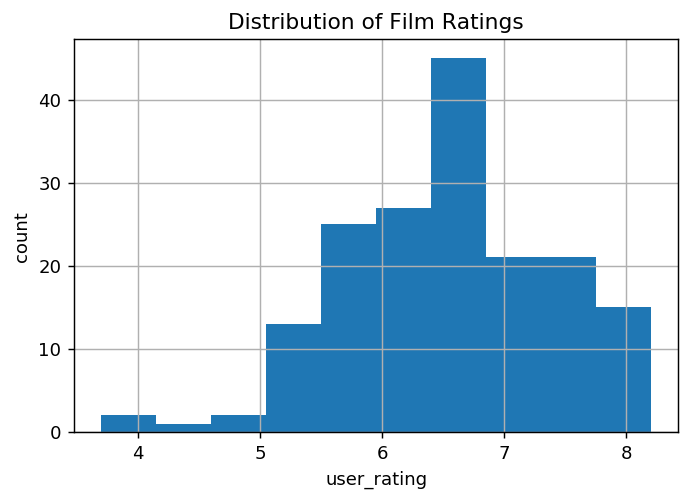

In [281]:
# a literal closer look at the histograms
plt.figure(dpi=130)
df_train['user_rating'].hist()
plt.xlabel('user_rating')
plt.ylabel('count')
plt.title('Distribution of Film Ratings')

In [251]:
# log transform
X_train['log_gross'] = np.log(X_train['avg_dir_gross']+1)
X_train['log_market'] = np.log(X_train['market_share']+1)
X_train['log_reviewers'] = np.log(X_train['reviewers']+1)
X_train['log_gap'] = np.log(X_train['year_gap']+1)

df_train['log_gross'] = np.log(df_train['avg_dir_gross']+1)
df_train['log_market'] = np.log(df_train['market_share']+1)
df_train['log_reviewers'] = np.log(df_train['reviewers']+1)
df_train['log_gap'] = np.log(df_train['year_gap']+1)

X_test['log_gross'] = np.log(X_test['avg_dir_gross']+1)
X_test['log_market'] = np.log(X_test['market_share']+1)
X_test['log_reviewers'] = np.log(X_test['reviewers']+1)
X_test['log_gap'] = np.log(X_test['year_gap']+1)

df_test['log_gross'] = np.log(df_test['avg_dir_gross']+1)
df_test['log_market'] = np.log(df_test['market_share']+1)
df_test['log_reviewers'] = np.log(df_test['reviewers']+1)
df_test['log_gap'] = np.log(df_test['year_gap']+1)

In [22]:
df_train.head()

,runtime,avg_dir_gross,family,war,thriller,mystery,western,adventure,crime,drama,...,mpaa_pg13,mpaa_r,book_rating,reviewers,year_gap,user_rating,log_gross,log_market,log_reviewers,log_gap
0,106.0,36690700.00,True,False,False,False,False,True,False,False,...,0,0,3.86,312428,5,6.1,17.418034,2.965273,12.652133,1.791759
1,97.0,0.00,False,False,False,False,False,False,False,True,...,1,0,3.83,140828,6,6.0,0.000000,2.965273,11.855302,1.945910
2,81.0,24737840.00,True,False,False,False,False,False,False,False,...,0,0,4.22,154301,42,6.2,17.023845,3.126761,11.946667,3.761200
3,119.0,0.00,False,False,False,False,False,False,False,True,...,1,0,3.92,104680,141,7.1,0.000000,2.631889,11.558673,4.955827
4,109.0,60242485.71,True,False,False,False,False,False,False,True,...,1,0,4.06,931087,5,7.4,17.913888,0.000000,13.744109,1.791759


In [136]:
# let's look at the frequency counts per genre
genre_freq = df_train[['family', 'war',
       'thriller', 'mystery', 'western', 'adventure', 'crime', 'drama',
       'comedy', 'romance', 'fantasy', 'horror', 'history', 'action',
       'musical', 'animation', 'scifi']].sum().reset_index(name='Freq').sort_values(by=['Freq'], ascending=False)
genre_freq

,index,Freq
7,drama,123
9,romance,56
5,adventure,42
8,comedy,41
13,action,33
10,fantasy,29
0,family,24
6,crime,21
3,mystery,20
2,thriller,20


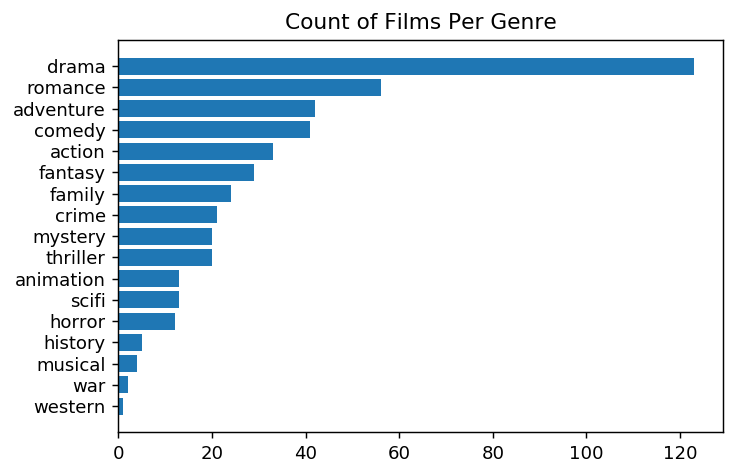

In [137]:
# plot above in a bar chart

labels = genre_freq['index']
values = genre_freq['Freq']
plt.figure(dpi=130)
plt.title('Count of Films Per Genre')
plt.barh(np.arange(len(labels)), values[::-1])
plt.yticks(np.arange(len(labels)),
           ['{}'.format(x) for x in labels[::-1]]);

Based on the frequency of genre values, the data is heavily skewed on drama. Over 70% (123/172) of the data points in the train set are dramas. Instead of looking at drama individually, it may be worthwhile to look at interactions of drama+other, perhaps with PolynomialFeatures in SKLearn.

In [252]:
df_train.columns

Index(['runtime', 'avg_dir_gross', 'family', 'war', 'thriller', 'mystery',
       'western', 'adventure', 'crime', 'drama', 'comedy', 'romance',
       'fantasy', 'horror', 'history', 'action', 'musical', 'animation',
       'scifi', 'dir_accomplished', 'market_share', 'mpaa_pg', 'mpaa_pg13',
       'mpaa_r', 'book_rating', 'reviewers', 'year_gap', 'user_rating',
       'log_gross', 'log_market', 'log_reviewers', 'log_gap'],
      dtype='object')

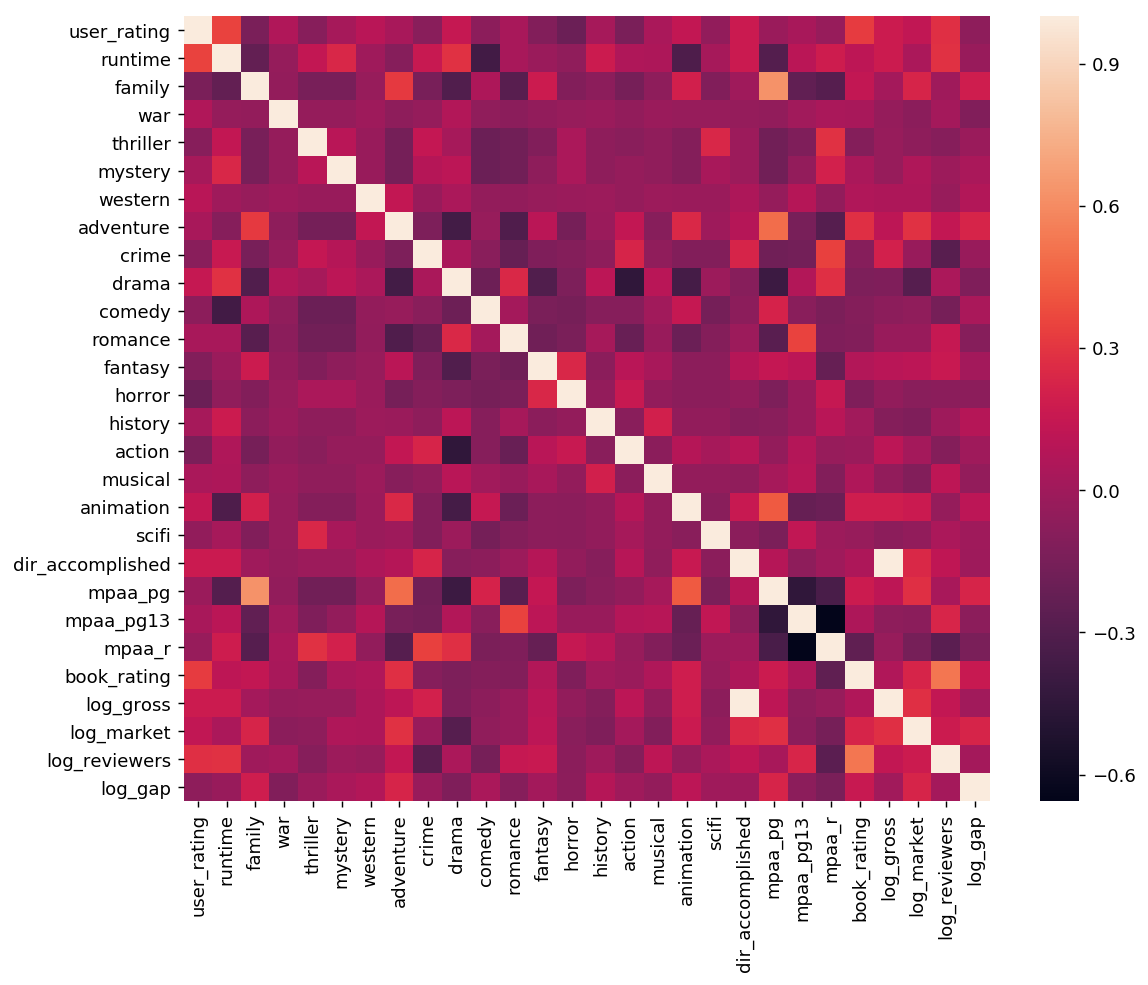

In [276]:
# another look at correlations heatmap after log transform

corr = df_train[['user_rating','runtime', 'family', 'war', 'thriller', 'mystery',
       'western', 'adventure', 'crime', 'drama', 'comedy', 'romance',
       'fantasy', 'horror', 'history', 'action', 'musical', 'animation',
       'scifi', 'dir_accomplished', 'mpaa_pg', 'mpaa_pg13',
       'mpaa_r', 'book_rating','log_gross', 'log_market', 'log_reviewers', 'log_gap']].corr()

# quick look at correlations heatmap
plt.figure(figsize=(10,8),dpi=130)
sns.heatmap(corr)

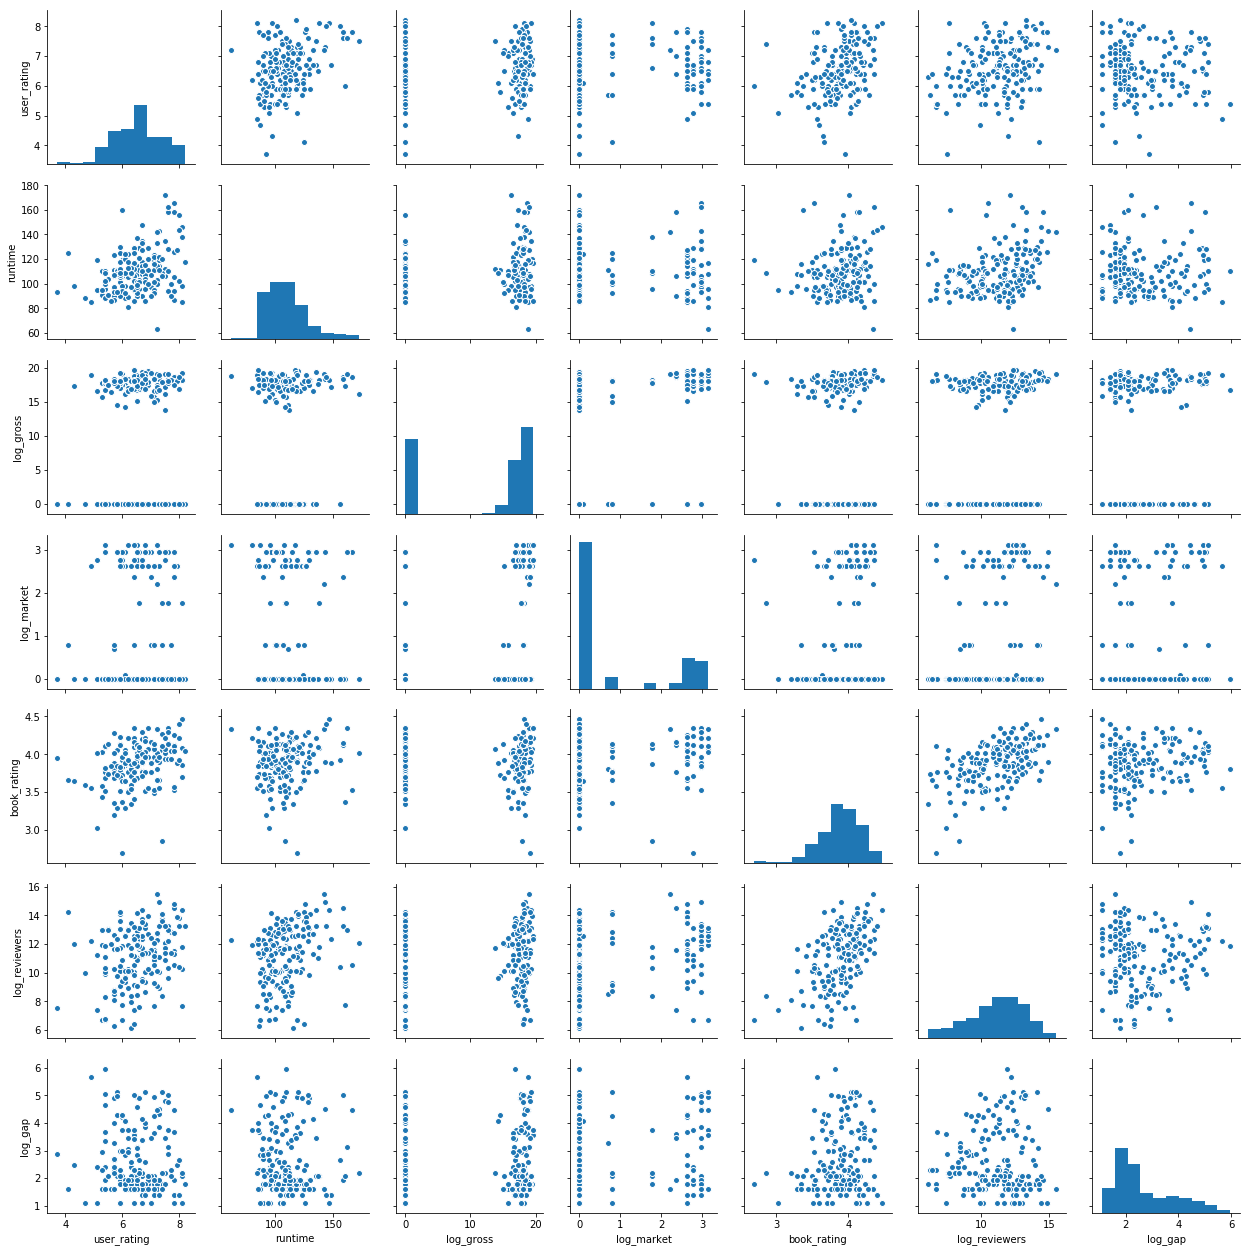

In [25]:
sns.pairplot(df_train[['user_rating','runtime','log_gross',
                       'log_market','book_rating','log_reviewers','log_gap']])

In [138]:
# scaling to normalize data between boolean and non boolean
ssX = StandardScaler()

ssX.fit(X_train)
X_train_s = ssX.transform(X_train)

Xy_train_s = np.concatenate((X_train_s, y_train.values.reshape(-1,1)), axis=1)

df_train_s = pd.DataFrame(Xy_train_s, columns=X_train.columns.tolist() + ['user_rating'])
df_train_s.head()

X_test_s = ssX.transform(X_test)
pickle.dump(X_train_s, open('pickles/X_train_s.pkl', 'wb'))
pickle.dump(df_train_s, open('pickles/df_train_s.pkl', 'wb'))
pickle.dump(X_test_s, open('pickles/X_test_s.pkl', 'wb'))

In [27]:
var_list = ['runtime', 'family', 'war', 'thriller', 'mystery',
       'western', 'adventure', 'crime', 'drama', 'comedy', 'romance',
       'fantasy', 'horror', 'history', 'action', 'musical', 'animation',
       'scifi', 'dir_accomplished', 'mpaa_pg', 'mpaa_pg13',
       'mpaa_r', 'book_rating', 'log_gross',
       'log_market', 'log_reviewers', 'log_gap']

In [139]:
# try linear regression with OLS
ols_f = 'user_rating'+' ~ '+' + '.join(var_list)
ols_model = smf.ols(ols_f, data=df_train_s)
# Fit the model
ols_fit = ols_model.fit()
# Print summary statistics of the model's performance
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            user_rating   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     3.683
Date:                Thu, 26 Apr 2018   Prob (F-statistic):           2.02e-07
Time:                        23:07:06   Log-Likelihood:                -168.14
No. Observations:                 172   AIC:                             392.3
Df Residuals:                     144   BIC:                             480.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.5244      0.054    121.732      0.000       6.418       6.630
runtime              0.3235      0.074      4.368      0.000       0.177       0.470
family              -0.2954      0.085     -3.471      0.001      -0.464      -0.127
war                 -0.0168      0.058     -0.290      0.772      -0.131       0.098
thriller            -0.1760      0.068     -2.590      0.011      -0.310      -0.042
mystery             -0.1407      0.066     -2.122      0.036      -0.272      -0.010
western              0.0357      0.056      0.632      0.529      -0.076       0.147
adventure           -0.1402      0.079     -1.769      0.079      -0.297       0.016
crime               -0.1788      0.072     -2.469      0.015      -0.322      -0.036
drama               -0.0948      0.090     -1.047      0.297      -0.274       0.084
comedy              -0.1150      0.077     -1.502      0.135      -0.266       0.036
romance             -0.2291      0.088     -2.602      0.010      -0.403      -0.055
fantasy             -0.1291      0.069     -1.873      0.063      -0.265       0.007
horror              -0.1742      0.067     -2.599      0.010      -0.307      -0.042
history             -0.0870      0.061     -1.438      0.153      -0.207       0.033
action              -0.2234      0.077     -2.903      0.004      -0.376      -0.071
musical             -0.0422      0.059     -0.719      0.473      -0.158       0.074
animation            0.1034      0.074      1.388      0.167      -0.044       0.251
scifi               -0.0907      0.063     -1.434      0.154      -0.216       0.034
dir_accomplished     0.1239      0.588      0.211      0.833      -1.038       1.286
mpaa_pg             -0.0203      0.173     -0.117      0.907      -0.363       0.322
mpaa_pg13           -0.1030      0.241     -0.427      0.670      -0.580       0.374
mpaa_r              -0.1042      0.236     -0.442      0.659      -0.570       0.362
book_rating          0.1729      0.070      2.455      0.015       0.034       0.312
log_gross           -0.0549      0.598     -0.092      0.927      -1.236       1.126
log_market           0.0575      0.064      0.892      0.374      -0.070       0.185
log_reviewers       -0.0020      0.075     -0.027      0.979      -0.150       0.146
log_gap             -0.0652      0.059     -1.112      0.268      -0.181       0.051
==============================================================================
Omnibus:                        4.597   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.768
Skew:                          -0.230   Prob(JB):                       0.0922
Kurtosis:                       3.674   Cond. No.                         30.5
=====================================================

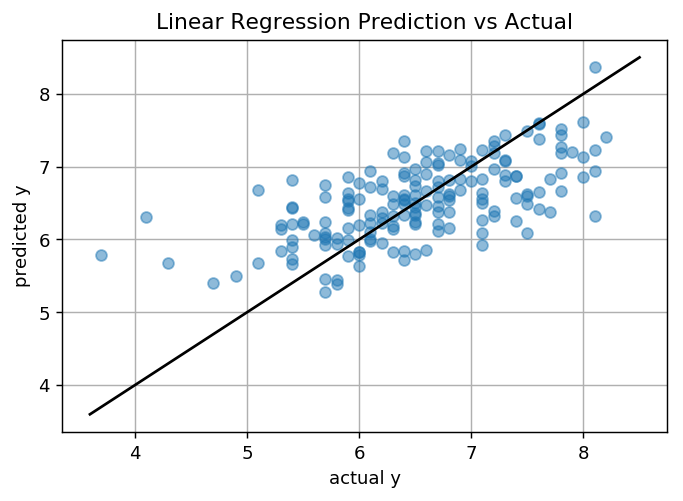

In [140]:
plt.figure(dpi=130)
plot_with_predict(df_train_s[var_list], y_train, ols_fit)
plt.plot([3.6,8.5],[3.6,8.5],'k')
plt.title('Linear Regression Prediction vs Actual');

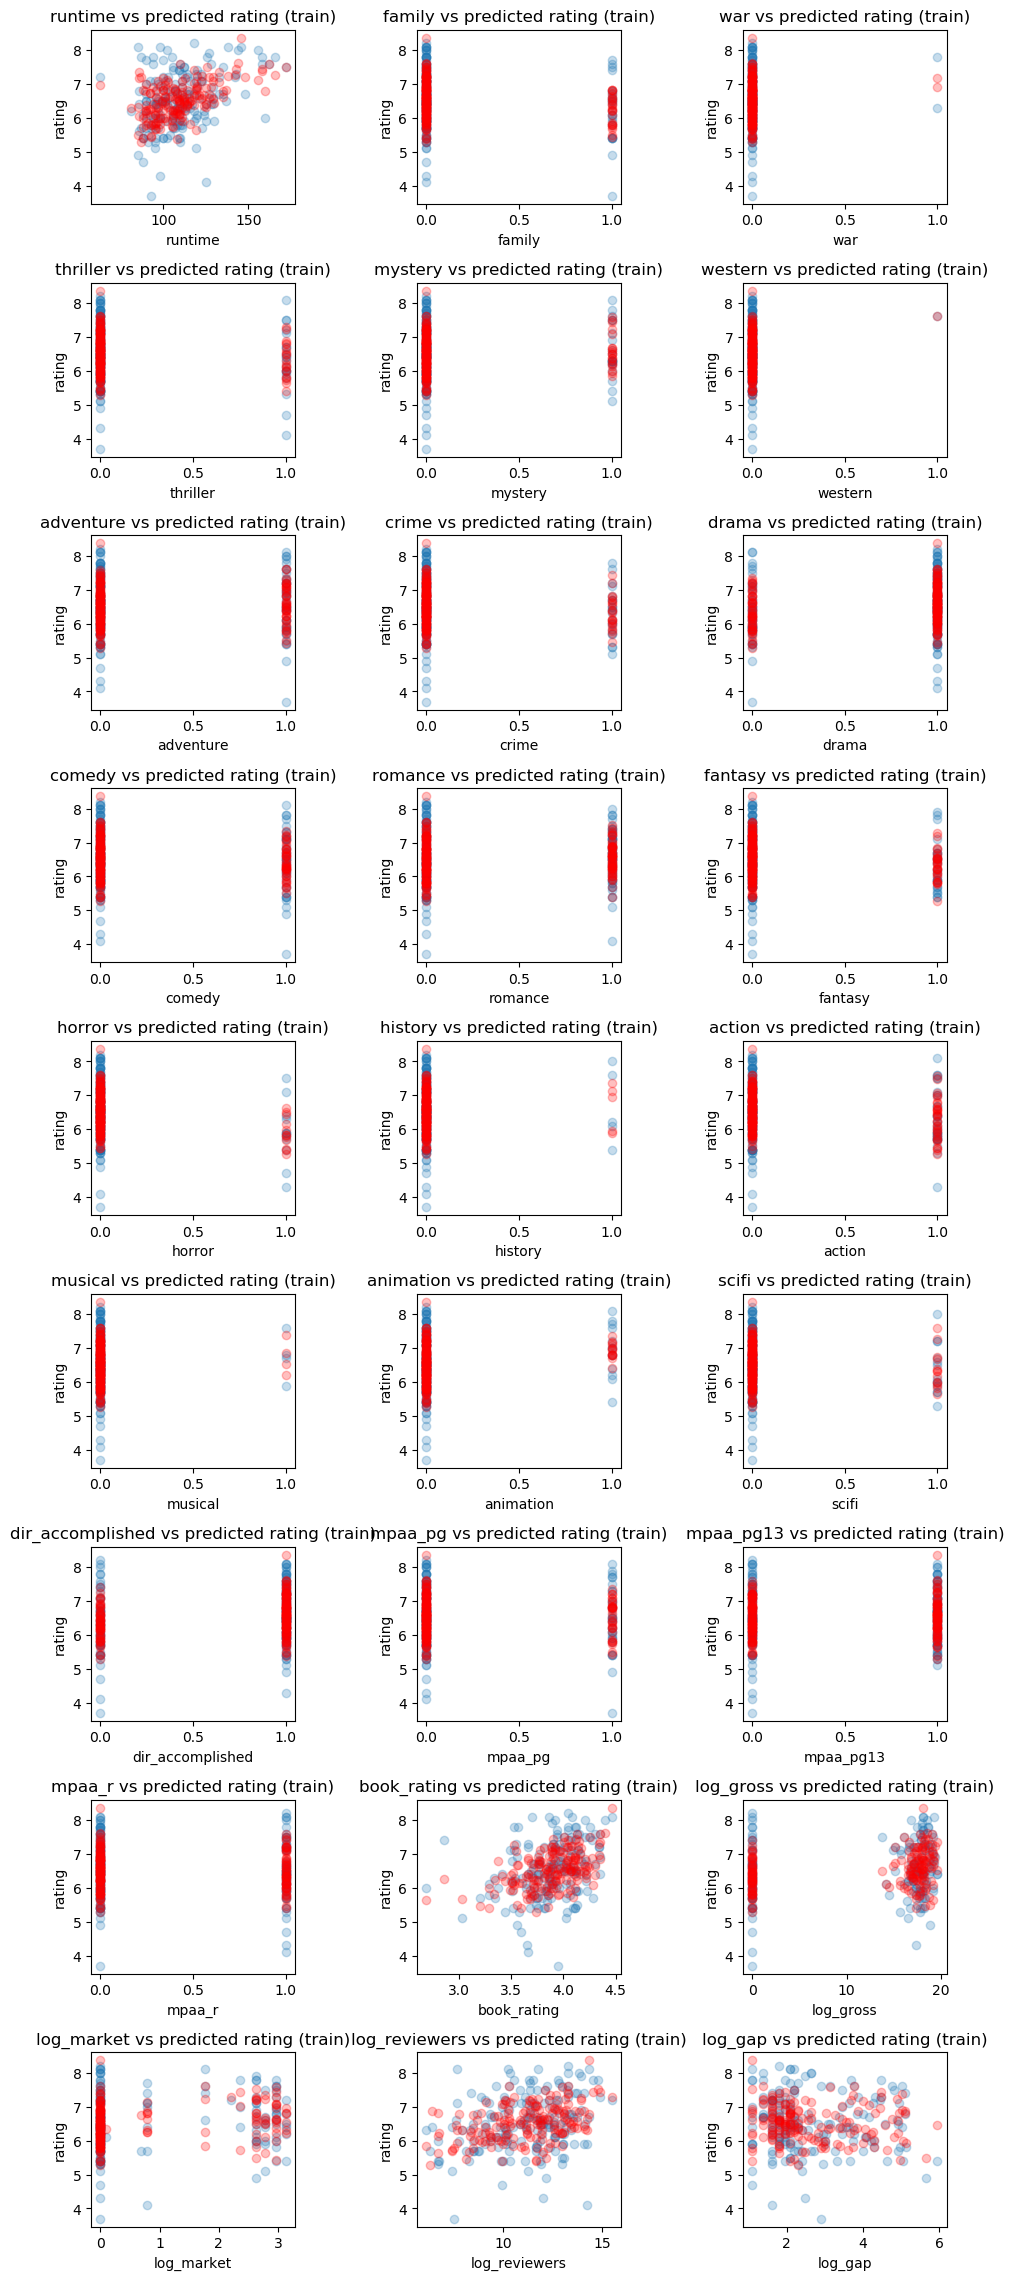

In [334]:
var_to_check = var_list
X = X_train
y_actual = y_train
y_predict = ols_fit.predict(df_train_s)

col_size = 3
row_size = round(len(var_to_check)/col_size,0)+1
fig=plt.figure(figsize=(10,2.5*row_size),dpi=100)
    
for i, var in enumerate(var_to_check):
    ax=fig.add_subplot(row_size,col_size,i+1)
    # use the unscaled X against the y that is predicted from the scaled X - scaling doesn't affect output
    # also, plotting the scaled X values is not helpful in understanding the affect of X on y prediction
    ax.plot(X[var], y_actual,'o', alpha=0.25, label='actual')
    ax.plot(X[var], y_predict,'ro', alpha=0.25, label='prediction')
    ax.set_title(var+' vs predicted rating (train)')
    ax.set_xlabel(var)
    ax.set_ylabel('rating')
    #ax.grid()
    #ax.legend()
fig.tight_layout()



From the plots above showing film rating per feature (actual and predicted), it seems there is high variance in the data and the model is predicting conservatively as a result. Which means that predicted values are lower when the ratings were very high, and predicted values are higher when the actual ratings were very low.

In [142]:
# linear regression using sklearn, and the corresponding R2
sklm = LinearRegression()
sklm.fit(df_train_s[var_list].values, y_train.values)
sklm.score(df_train_s[var_list].values, y_train.values)

0.4084636505788103

In [143]:
predictions = sklm.predict(df_train_s[var_list])
mae = np.mean(abs(predictions - y_train.values))
rmse = np.sqrt(np.mean((predictions - y_train.values)**2))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.5
RMSE = 0.64


RMSE is higher than MAE, so that means there is high variation in errors because RMSE is more sensitive to higher errors. I want to take a closer look at the errors for each of the non-categorical features to see if any of them are not contributing  well to the model. Based on what I am trying to predict - the user rating of a film out of a 10 point scale - and what I am trying to use it for - whether a film is "good" and should be viewed - I am okay with an error of +/- 1 point. 

Text(0.5,1,'Residuals on Train Data')

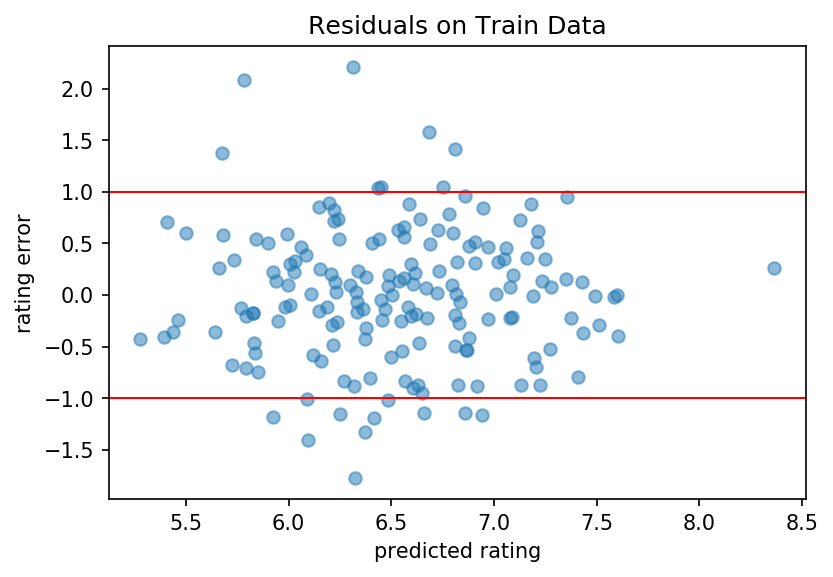

In [231]:
y_predict = sklm.predict(df_train_s[var_list])
plt.figure(dpi=150)
plt.plot(y_predict,y_predict-y_train,'o', alpha=0.5)
plt.axhline(+1,color='r',lw=1,ls='-')
plt.axhline(-1,color='r',lw=1,ls='-')
plt.xlabel('predicted rating')
plt.ylabel('rating error')
plt.title('Residuals on Train Data')

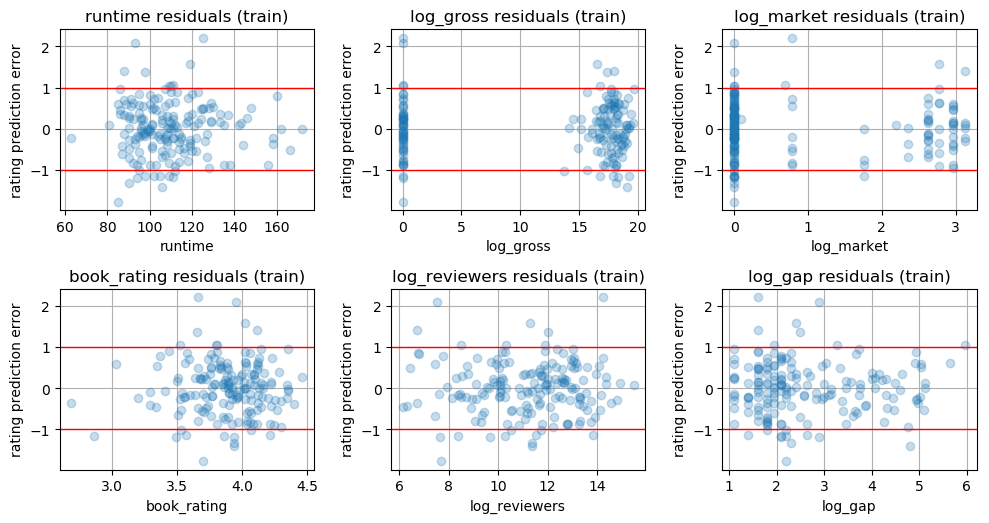

In [144]:
var_to_check = ['runtime','log_gross','log_market','book_rating','log_reviewers','log_gap']
plot_residuals(df_train,y_predict,y_train,var_to_check)

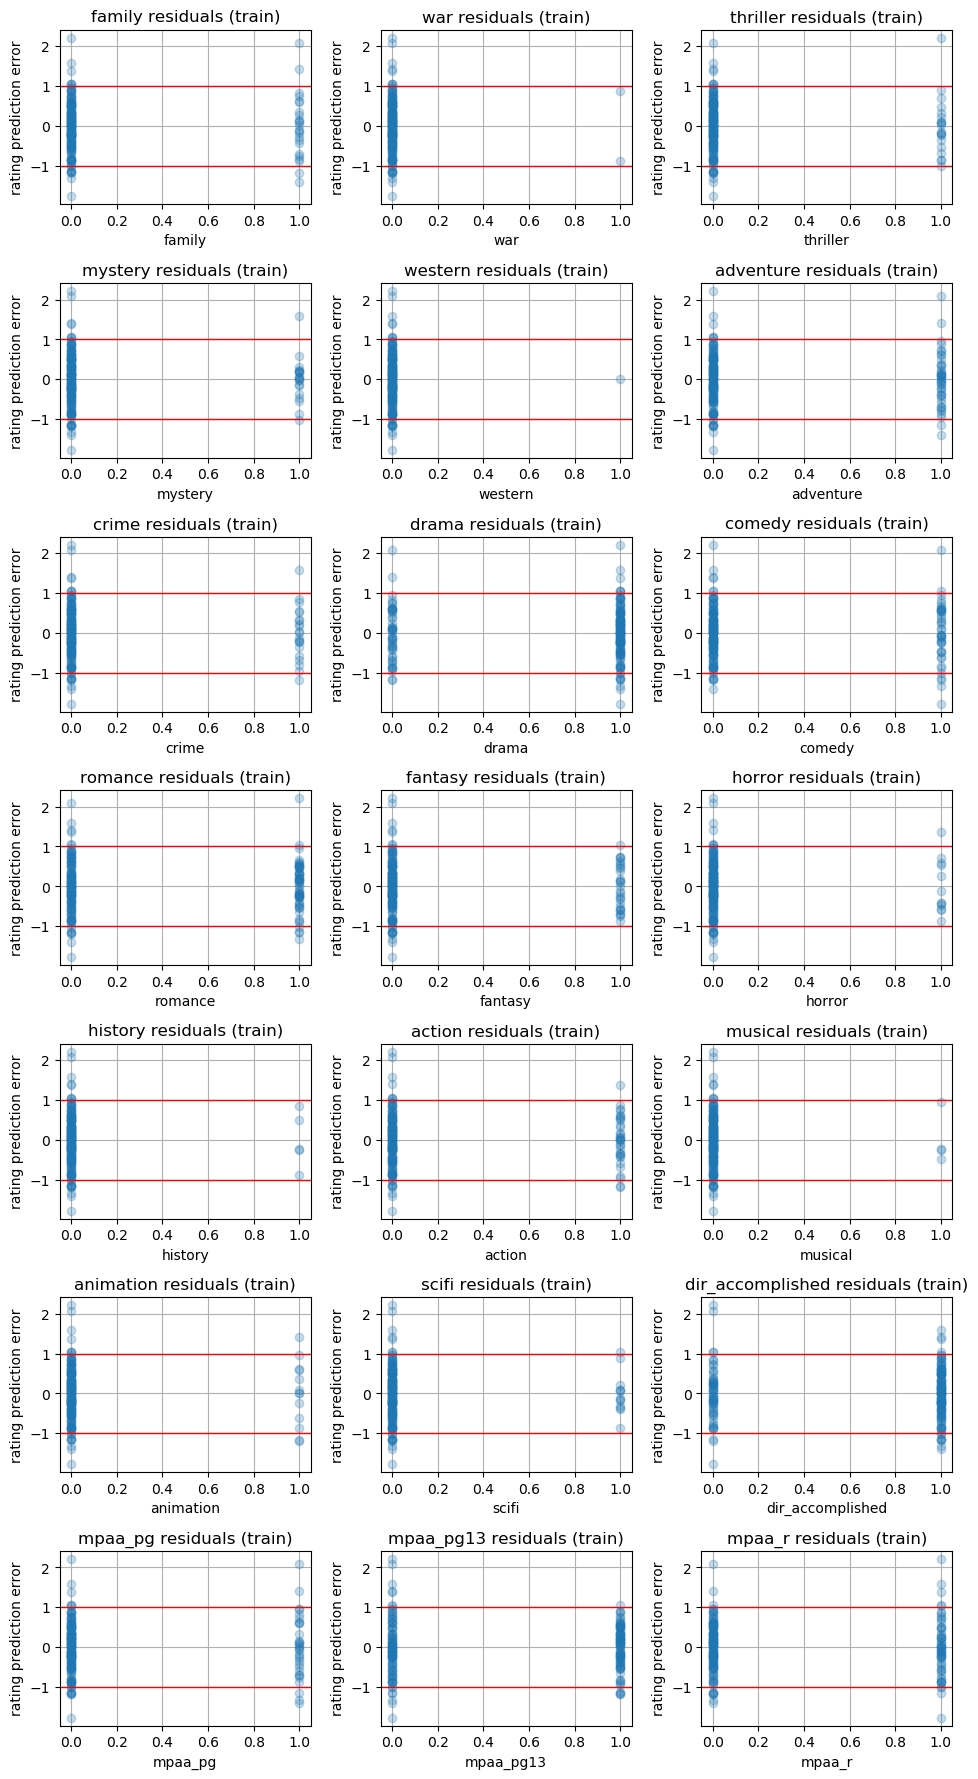

In [145]:
var_to_check = ['family', 'war', 'thriller', 'mystery',
       'western', 'adventure', 'crime', 'drama', 'comedy', 'romance',
       'fantasy', 'horror', 'history', 'action', 'musical', 'animation',
       'scifi', 'dir_accomplished',  'mpaa_pg', 'mpaa_pg13',
       'mpaa_r']

y_predict = sklm.predict(df_train_s[var_list])
plot_residuals(df_train,y_predict,y_train,var_to_check)

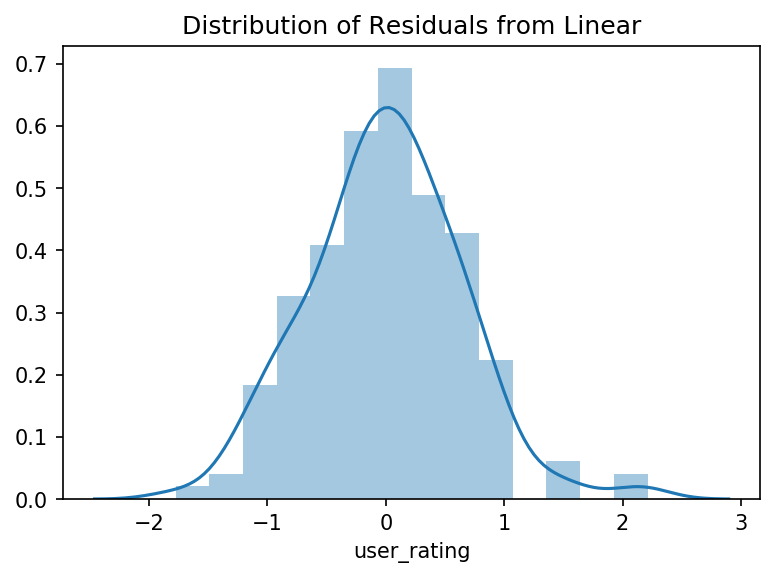

In [232]:
# residuals have a mostly normal distribution
residuals_linear = y_predict - y_train
plt.figure(dpi=150)
sns.distplot(residuals_linear)
plt.title('Distribution of Residuals from Linear');

It appears the majority of film ratings is predicted within the +/- 1 point range. The basic linear regression with all features is relatively bad at predicting ratings for films that fall within certain groups: R rated, PG rated, comedy, drama, adventure, and family, for example. The residuals have a normal distribution centered around 0, which indicates that the assumptions underlying the linear regression are sound and that the model is doing a fairly good job of capturing the pattern.
Let's look at what these outliers are to see if there is a trend.

In [147]:
# create dataframe within which to CHECK for outliers outside the +/- 1 tolerance
df_check_outliers = df_train[df_train.columns[:-5]].copy()
df_check_outliers['error'] = round((sklm.predict(df_train_s[var_list]) - y_train),1)
df_check_outliers['actual'] = y_train
df_check_outliers['predict'] = np.round(sklm.predict(df_train_s[var_list]),1)
var_list_genre = ['family', 'war', 'thriller', 'mystery',
       'western', 'adventure', 'crime', 'drama', 'comedy', 'romance',
       'fantasy', 'horror', 'history', 'action', 'musical', 'animation',
       'scifi']
df_check_outliers[abs(df_check_outliers['error'])>1].sort_values(by=['error'],ascending=False)

,runtime,avg_dir_gross,family,war,thriller,mystery,western,adventure,crime,drama,...,market_share,mpaa_pg,mpaa_pg13,mpaa_r,book_rating,reviewers,year_gap,error,actual,predict
35,125.0,0.000000e+00,False,False,True,False,False,False,False,True,...,1.2,0,0,1,3.66,1532929,4,2.2,4.1,6.3
65,93.0,0.000000e+00,True,False,False,False,False,True,False,False,...,0.0,1,0,0,3.95,1856,17,2.1,3.7,5.8
36,119.0,1.535135e+07,False,False,False,True,False,False,True,True,...,15.0,0,0,1,4.02,78562,10,1.6,5.1,6.7
95,88.0,6.653915e+07,True,False,False,False,False,True,False,False,...,21.8,1,0,0,4.11,809,4,1.4,5.4,6.8
150,98.0,3.433873e+07,False,False,False,False,False,False,False,True,...,0.0,0,0,1,3.65,163717,11,1.4,4.3,5.7
11,111.0,0.000000e+00,False,False,False,False,False,False,False,True,...,1.0,0,0,1,3.80,4870,25,1.1,5.7,6.8
61,102.0,2.025470e+07,False,False,False,False,False,False,False,True,...,0.0,0,1,0,4.21,1023591,13,-1.1,8.0,6.9
101,105.0,0.000000e+00,False,False,False,False,False,False,False,True,...,0.0,0,1,0,3.57,103004,3,-1.1,7.8,6.7
13,98.0,2.309861e+08,False,False,False,False,False,True,False,False,...,0.0,1,0,0,3.86,28556,7,-1.2,8.1,6.9
15,111.0,9.382220e+07,False,False,False,False,False,False,True,False,...,0.0,0,1,0,3.49,2114,7,-1.2,7.1,5.9


In [148]:
# ID outliers
for i in df_check_outliers[abs(df_check_outliers['error'])>1]['reviewers']:
    print(df_bookdata[df_bookdata['reviewers']==i]['title'].values, i)

['Radio Free Albemuth'] 4870
['How to Train Your Dragon'] 28556
['RED'] 2114
['Fifty Shades of Grey'] 1532929
['The Snowman'] 78562
['The Perks of Being a Wallflower'] 1023591
['Horrid Henry: The Movie'] 1856
['Mars Needs Moms'] 809
['Me and Earl and the Dying Girl'] 103004
['The Jungle Book'] 86877
['The Breadwinner'] 15591
['Flipped'] 85610
['The House of Tomorrow'] 2127
['Up in the Air'] 4309
['Cell'] 163717


Based on the tolerance criteria, there are 15 out of 172 datapoints that would be considered outliers. This amounts to about 8.7%, which I think is pretty good. But I know there could be room for improvement with feature engineering because each film can fall under multiple genres, so let's take a look at the MAE per genre. 

In [312]:
genre_list = ['family', 'war','thriller', 'mystery', 'western', 'adventure', 'crime', 'drama','comedy', 'romance', 'fantasy', 'horror', 'history', 'action','musical', 'animation', 'scifi']
df_check_outliers['index'] = df_check_outliers.index
df_genre_melt = df_check_outliers.melt(id_vars='index', value_vars=genre_list)
# sorry, Zach..
df_genre_error = df_check_outliers.merge(df_genre_melt[df_genre_melt['value']], left_index = True, right_on='index', how='left')[['variable','value','error']]
df_genre_error['abs_error'] = df_genre_error['error'].apply(lambda x: abs(x))
df_genre_error_avg = df_genre_error.groupby(['variable'])['variable','abs_error'].mean().reset_index()
df_genre_count = df_genre_error.groupby(['variable'])['variable','value'].sum().reset_index()
df_genre_perf = df_genre_error_avg.merge(df_genre_count,how='inner',on='variable').sort_values(by=['abs_error'],ascending=True)
df_genre_perf.rename(columns={'variable':'genre','abs_error':'avg_error','value':'count'},inplace=True)

In [330]:
df_genre_perf

,genre,avg_error,count
16,western,0.000000,1.0
11,mystery,0.360000,20.0
13,scifi,0.384615,13.0
7,fantasy,0.468966,29.0
12,romance,0.471429,56.0
0,action,0.472727,33.0
5,drama,0.482927,123.0
10,musical,0.500000,4.0
4,crime,0.504762,21.0
1,adventure,0.507143,42.0


In [331]:
df_temp = df_train[df_train.columns].copy()
df_genre_rating = df_temp.merge(df_genre_melt[df_genre_melt['value']], left_index = True, right_on='index', how='left')[['variable','value','user_rating']]
df_genre_rating_avg = df_genre_rating.groupby(['variable'])['variable','user_rating'].mean().reset_index()
df_genre_rating_avg = df_genre_rating_avg.merge(df_genre_count,how='inner',on='variable').sort_values(by=['user_rating'],ascending=True)

In [333]:
df_genre_rating_avg.sort_values(by='user_rating',ascending=False)

,variable,user_rating,value
16,western,7.600000,1.0
15,war,7.050000,2.0
2,animation,6.930769,13.0
10,musical,6.750000,4.0
8,history,6.660000,5.0
5,drama,6.603252,123.0
11,mystery,6.585000,20.0
1,adventure,6.571429,42.0
12,romance,6.562500,56.0
3,comedy,6.421951,41.0


One of the charts above shows the average error per genre, and how many films were included in each genre in the training dataset. For example, the average error for westerns is 0, but there was also only 1 western film in the dataset. At this point it's not certain that there is any genre that performs better or worse in the model, so I'll let regularization with lasso decide. 

In [150]:
# lasso with linear
lasso_model = Lasso(max_iter=5000)
parameters = {'alpha':[1e-5, 1e-3, 1, 10, 100], 'fit_intercept':[True, False]}
lasso_grid = GridSearchCV(lasso_model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
lasso_grid.fit(df_train_s[var_list], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.001, 1, 10, 100], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [151]:
# best param - alpha = 0.001, intercept = True
# MAE score around 0.6 for test, around 0.48 for train - some concern of overfitting
lasso_grid.cv_results_

{'mean_fit_time': array([0.0100265 , 0.0115304 , 0.00381002, 0.0063168 , 0.00170441,
        0.00160418, 0.00160432, 0.00140433, 0.00160375, 0.00140376]),
 'mean_score_time': array([0.00040121, 0.00040116, 0.00030093, 0.0005013 , 0.00040112,
        0.00030098, 0.00030079, 0.00030103, 0.00010028, 0.0005013 ]),
 'mean_test_score': array([ -0.62566736, -17.87139026,  -0.62207576, -17.8401707 ,
         -0.66681329,  -6.52441862,  -0.66681329,  -6.52441862,
         -0.66681329,  -6.52441862]),
 'mean_train_score': array([-0.48777297, -3.94007667, -0.48716273, -3.94101494, -0.66405864,
        -6.52441237, -0.66405864, -6.52441237, -0.66405864, -6.52441237]),
 'param_alpha': masked_array(data=[1e-05, 1e-05, 0.001, 0.001, 1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False, True, False, True, False, Tr

In [152]:
lasso_grid.best_estimator_.coef_

array([ 0.31861659, -0.28419445, -0.01290247, -0.16896846, -0.1331943 ,
        0.03538566, -0.12964215, -0.17248113, -0.08437872, -0.10423401,
       -0.21740773, -0.12277906, -0.16892114, -0.08351467, -0.21712241,
       -0.03903546,  0.10894988, -0.08677631,  0.06907677,  0.        ,
       -0.0665148 , -0.06698861,  0.17392012,  0.        ,  0.05554528,
       -0.        , -0.06414817])

In [153]:
# look at p values based on non-zeros in lasso_grid result
var_list_cut = ['runtime', 'family', 'war', 'thriller', 'mystery', 'western',
       'adventure', 'crime', 'drama', 'comedy', 'romance', 'fantasy', 'horror',
       'history', 'action', 'musical', 'animation', 'scifi',
       'dir_accomplished','mpaa_pg13', 'mpaa_r', 'book_rating',
       'log_market','log_gap']

ols_f = 'user_rating'+' ~ '+' + '.join(var_list_cut)
ols_model_cut = smf.ols(ols_f, data=df_train_s)
# Fit the model
ols_fit_cut = ols_model_cut.fit()
# Print summary statistics of the model's performance
ols_fit_cut.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            user_rating   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     4.228
Date:                Thu, 26 Apr 2018   Prob (F-statistic):           2.33e-08
Time:                        23:07:55   Log-Likelihood:                -168.16
No. Observations:                 172   AIC:                             386.3
Df Residuals:                     147   BIC:                             465.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.5244      0.053    122.984      0.000       6.420       6.629
runtime              0.3205      0.068      4.717      0.000       0.186       0.455
family              -0.2964      0.084     -3.544      0.001      -0.462      -0.131
war                 -0.0174      0.057     -0.303      0.762      -0.131       0.096
thriller            -0.1753      0.066     -2.637      0.009      -0.307      -0.044
mystery             -0.1396      0.064     -2.174      0.031      -0.266      -0.013
western              0.0357      0.055      0.643      0.521      -0.074       0.145
adventure           -0.1404      0.078     -1.794      0.075      -0.295       0.014
crime               -0.1780      0.070     -2.555      0.012      -0.316      -0.040
drama               -0.0941      0.089     -1.063      0.290      -0.269       0.081
comedy              -0.1144      0.075     -1.516      0.132      -0.264       0.035
romance             -0.2292      0.086     -2.655      0.009      -0.400      -0.059
fantasy             -0.1293      0.067     -1.917      0.057      -0.263       0.004
horror              -0.1744      0.066     -2.633      0.009      -0.305      -0.044
history             -0.0867      0.060     -1.455      0.148      -0.204       0.031
action              -0.2243      0.076     -2.964      0.004      -0.374      -0.075
musical             -0.0429      0.058     -0.743      0.459      -0.157       0.071
animation            0.1034      0.072      1.432      0.154      -0.039       0.246
scifi               -0.0915      0.062     -1.469      0.144      -0.214       0.032
dir_accomplished     0.0700      0.060      1.171      0.243      -0.048       0.188
mpaa_pg13           -0.0776      0.118     -0.659      0.511      -0.310       0.155
mpaa_r              -0.0793      0.127     -0.624      0.534      -0.331       0.172
book_rating          0.1733      0.060      2.890      0.004       0.055       0.292
log_market           0.0558      0.062      0.896      0.372      -0.067       0.179
log_gap             -0.0649      0.058     -1.122      0.264      -0.179       0.049
==============================================================================
Omnibus:                        4.613   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.748
Skew:                          -0.235   Prob(JB):                       0.0931
Kurtosis:                       3.665   Cond. No.                         6.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
# create dataframe within which to CHECK for outliers outside the +/- 1 tolerance
df_check_outliers2 = df_train[df_train.columns[:-5]].copy()
df_check_outliers2['error'] = round((lasso_grid.best_estimator_.predict(df_train_s[var_list]) - y_train),1)
df_check_outliers2['actual'] = y_train
df_check_outliers2['predict'] = np.round(lasso_grid.best_estimator_.predict(df_train_s[var_list]),1)
df_check_outliers2[abs(df_check_outliers2['error'])>1].shape[0]

15

In [155]:
#compare outliers between the linear and linear with lasso
[df_check_outliers[abs(df_check_outliers['error'])>1].reset_index().sort_values(by=['index']).index.tolist(),
 df_check_outliers2[abs(df_check_outliers2['error'])>1].reset_index().sort_values(by=['index']).index.tolist()
]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

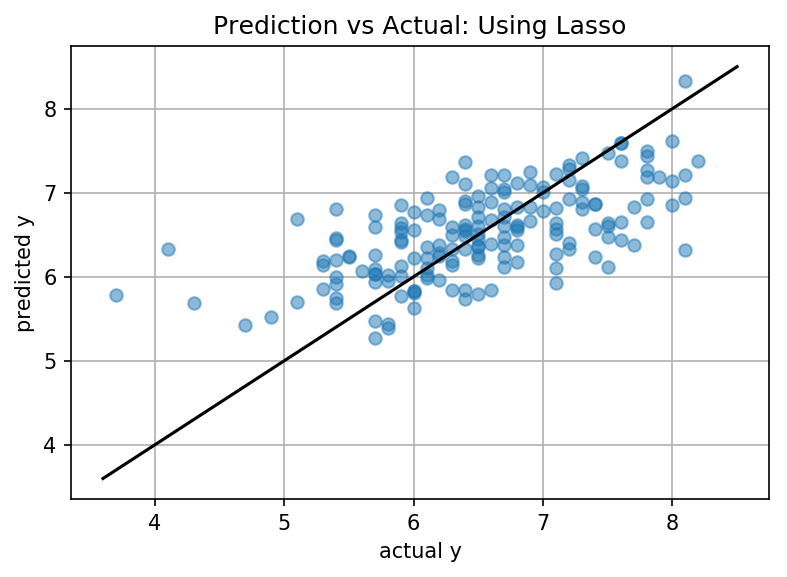

In [239]:
plt.figure(dpi=150)
plot_with_predict(df_train_s[var_list], y_train, lasso_grid.best_estimator_)
plt.plot([3.6,8.5],[3.6,8.5],'k')
plt.title('Prediction vs Actual: Using Lasso');

In [157]:
# MAE and RMSE are about the same as original OLS linear
predictions = lasso_grid.best_estimator_.predict(df_train_s[var_list])
rmse = np.sqrt(np.mean((predictions - y_train.values)**2))
mae = np.mean(abs(predictions - y_train.values))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.5
RMSE = 0.64


Text(0.5,1,'Residuals on Train Data using Lasso')

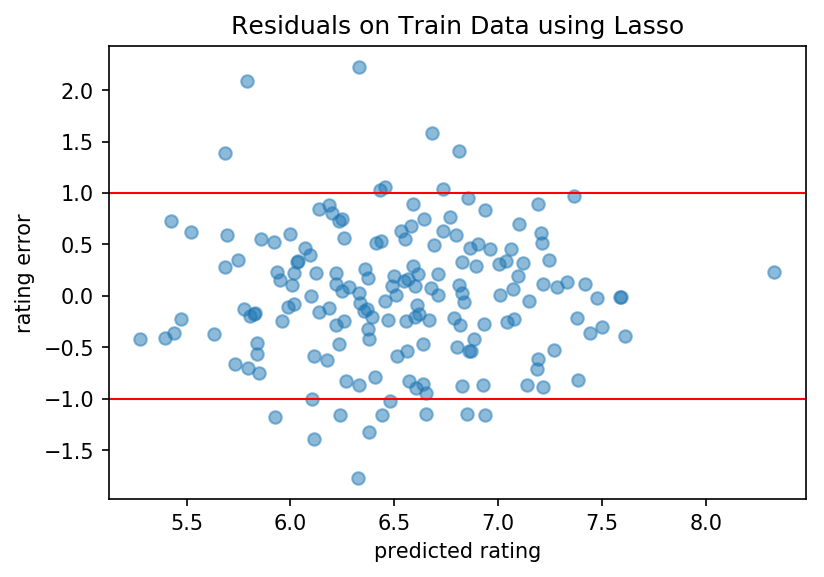

In [240]:
y_predict = lasso_grid.best_estimator_.predict(df_train_s[var_list])

plt.figure(dpi=150)
plt.plot(y_predict,y_predict-y_train,'o', alpha=0.5)
plt.axhline(+1,color='r',lw=1,ls='-')
plt.axhline(-1,color='r',lw=1,ls='-')
plt.xlabel('predicted rating')
plt.ylabel('rating error')
plt.title('Residuals on Train Data using Lasso');

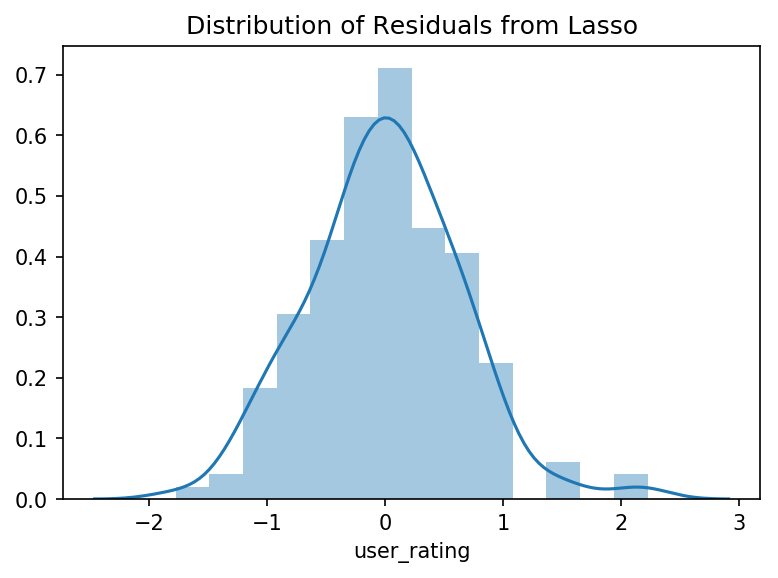

In [238]:
# residuals have a mostly normal distribution
residuals_lasso = y_predict - y_train
plt.figure(dpi=150)
sns.distplot(residuals_lasso)
plt.title('Distribution of Residuals from Lasso');

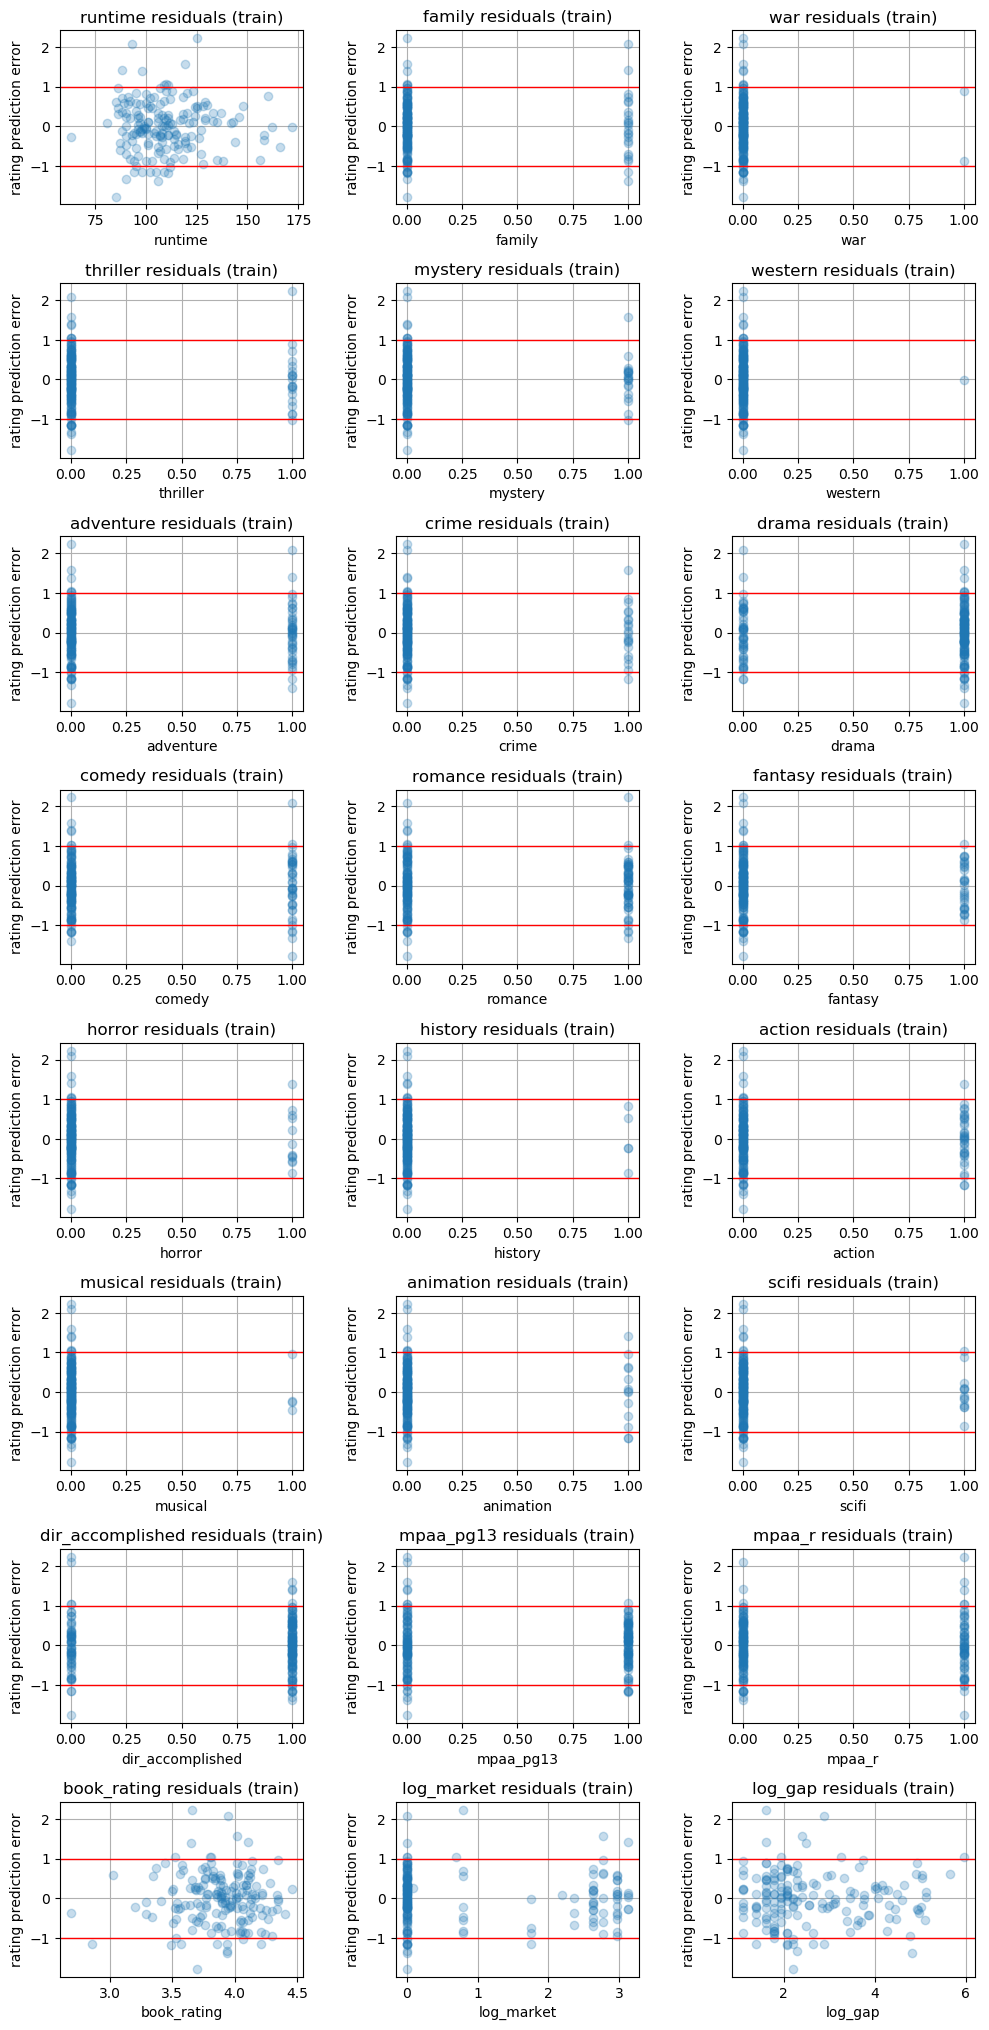

In [158]:
var_to_check = var_list_cut
plot_residuals(df_train,y_predict,y_train,var_to_check)

In [159]:
# lasso with polynomial to look for any strong interactions
degree = 2
poly_lasso_model = make_pipeline(PolynomialFeatures(degree),Lasso(max_iter=5000))
parameters = {'lasso__alpha':[1e-5, 1e-3, 1, 10, 100], 'lasso__fit_intercept':[True, False]}
poly_lasso_grid = GridSearchCV(poly_lasso_model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
poly_lasso_grid.fit(df_train_s[var_list], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': [1e-05, 0.001, 1, 10, 100], 'lasso__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [160]:
# best param - alpha = 1, intercept = True
# MAE score around 0.67 for test, around 0.66 for train so this is pretty good
poly_lasso_grid.cv_results_

{'mean_fit_time': array([0.36878071, 0.08873544, 0.29608741, 0.09364872, 0.00671806,
        0.02606931, 0.00711937, 0.00782099, 0.00741992, 0.00721955]),
 'mean_score_time': array([0.00340943, 0.00511389, 0.00551529, 0.00561528, 0.00451169,
        0.00401092, 0.0069181 , 0.0056149 , 0.00471206, 0.00511365]),
 'mean_test_score': array([-1.48777624, -1.47483921, -1.08571346, -1.1068322 , -0.66674282,
        -1.22159678, -0.66681329, -6.52441862, -0.66681329, -6.52441862]),
 'mean_train_score': array([-6.56844505e-04, -5.44092715e-03, -3.68182206e-02, -3.64838322e-02,
        -6.62436106e-01, -1.08195731e+00, -6.64058638e-01, -6.52441237e+00,
        -6.64058638e-01, -6.52441237e+00]),
 'param_lasso__alpha': masked_array(data=[1e-05, 1e-05, 0.001, 0.001, 1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_lasso__fit_intercept': masked_array(dat

In [161]:
# ...but nearly all the coefs are 0
poly_lasso_grid.best_estimator_.steps[-1][1].coef_

array([ 0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Lasso found one interaction that was significant enough that no other features mattered. This isn't what I'm looking for so I'll try Ridge next.

In [162]:
# ridge with polynomial
degree = 2
poly_ridge_model = make_pipeline(PolynomialFeatures(degree),Ridge(max_iter=5000))
parameters = {'ridge__alpha':[1e-5, 1e-3, 1, 10, 100], 'ridge__fit_intercept':[True, False]}
poly_ridge_grid = GridSearchCV(poly_ridge_model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
poly_ridge_grid.fit(df_train_s[var_list], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [1e-05, 0.001, 1, 10, 100], 'ridge__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [163]:
# best param - alpha = 100, intercept = True
# MAE score around 0.63 for test, around 0.2 for train so this is definitely overfitting
poly_ridge_grid.cv_results_

{'mean_fit_time': array([0.01062818, 0.01002665, 0.00852242, 0.00972586, 0.0092247 ,
        0.00972624, 0.00812469, 0.00741968, 0.00902433, 0.00812201]),
 'mean_score_time': array([0.00621657, 0.00611615, 0.00611658, 0.00581503, 0.00571494,
        0.00661783, 0.00501037, 0.00501332, 0.0059155 , 0.00581574]),
 'mean_test_score': array([-1.49912778, -1.57535772, -1.49712721, -1.57323835, -1.14433243,
        -1.26503881, -0.8310676 , -1.05551609, -0.63126603, -1.19527566]),
 'mean_train_score': array([-8.19337298e-07, -9.16310697e-07, -8.15104401e-05, -9.08102281e-05,
        -3.16937687e-02, -3.42520643e-02, -1.11636603e-01, -1.41039908e-01,
        -2.70387262e-01, -5.07443472e-01]),
 'param_ridge__alpha': masked_array(data=[1e-05, 1e-05, 0.001, 0.001, 1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_ridge__fit_intercept': masked_array(dat

In [164]:
# nothing stands out here
poly_ridge_grid.best_estimator_.steps[-1][1].coef_

array([ 0.00000000e+00,  8.43704516e-02, -1.15083834e-02, -1.69399156e-04,
       -6.71083190e-03, -5.63932597e-03,  4.38619185e-04, -1.41325055e-03,
       -7.35824148e-03,  4.21469483e-03, -3.03679395e-02, -1.74243346e-02,
       -2.89532223e-03, -5.90703338e-03, -3.08921320e-03, -4.26597419e-02,
       -1.76814175e-03,  1.13583387e-02, -4.52615157e-03,  1.68437326e-02,
        1.98802325e-02, -2.10452521e-02, -1.18244426e-03,  7.74835961e-02,
        1.85453309e-02,  1.87897312e-02,  2.95016716e-02, -1.53284162e-02,
        4.96745100e-02, -5.50280844e-03, -1.43688611e-02, -3.89934021e-03,
        3.11457349e-02, -6.44404324e-03,  1.82438339e-02,  2.31794761e-02,
        1.28746542e-02, -2.03221804e-02, -2.42562225e-02,  2.14857587e-02,
        5.00177283e-02,  2.78582197e-02,  7.37957421e-04, -4.04788259e-04,
       -3.24501361e-02, -3.88883387e-03, -7.25196350e-03, -1.55004548e-02,
        2.41617227e-02, -4.36456088e-04,  2.17784011e-02,  3.01716186e-03,
        2.76562457e-02,  

In [165]:
# ridge with linear
ridge_model = Ridge(max_iter=5000)
parameters = {'alpha':[1e-5, 1e-3, 1, 10, 100], 'fit_intercept':[True, False]}
ridge_grid = GridSearchCV(ridge_model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
ridge_grid.fit(df_train_s[var_list], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.001, 1, 10, 100], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [166]:
# best param - alpha = 100, intercept = True
# MAE score around 0.6 for test, around 0.5 for train 
ridge_grid.cv_results_

{'mean_fit_time': array([0.00160446, 0.00491261, 0.00210543, 0.00190506, 0.0017046 ,
        0.00170584, 0.00180488, 0.00180449, 0.0014039 , 0.00150414]),
 'mean_score_time': array([0.00040107, 0.00080309, 0.00020056, 0.00040212, 0.00030084,
        0.00029969, 0.00030112, 0.00030107, 0.00050168, 0.00030074]),
 'mean_test_score': array([ -0.62569977, -17.87158622,  -0.62568928, -17.85942002,
         -0.62013216, -12.81232496,  -0.60647106,  -8.42711771,
         -0.59430039,  -7.11508351]),
 'mean_train_score': array([-0.48778115, -3.94007015, -0.48777945, -3.93999034, -0.48698396,
        -4.95619625, -0.48894705, -6.0493549 , -0.52731704, -6.37674663]),
 'param_alpha': masked_array(data=[1e-05, 1e-05, 0.001, 0.001, 1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False, True, False, True, False, Tr

In [167]:
ridge_grid.best_estimator_.coef_

array([ 0.16527803, -0.09261759,  0.02335699, -0.05292522, -0.01842139,
        0.03781638, -0.01195553, -0.05773629,  0.0361671 , -0.01042522,
       -0.03384644, -0.05012751, -0.07760363, -0.0121094 , -0.07269473,
       -0.00019958,  0.09072475, -0.02743546,  0.03215599, -0.00186474,
       -0.00863515, -0.00427428,  0.12079602,  0.03922945,  0.04047878,
        0.05543065, -0.04550306])

In [168]:
# MAE and RMSE are higher than OLS linear and linear with lasso
predictions = ridge_grid.best_estimator_.predict(df_train_s[var_list])
rmse = np.sqrt(np.mean((predictions - y_train.values)**2))
mae = np.mean(abs(predictions - y_train.values))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.53
RMSE = 0.69


With regularization, 4 models were investigated:
* Lasso - this zeroed out log_reviewers, log_gross, and mpaa_pg
* Lasso with polynomial - this zeroed out nearly all features
* Ridge with polynomial - significant overfitting
* Ridge - slightly higher error metrics than lasso

From here, I can try to tweak the alpha to get lower MAE on the linear lasso or ridge. Because there are still so many genres represented, I will use lasso to see if any more can be removed when running without log_reviewers, log_gross, and mpaa_pg.

In [169]:
# lasso with linear, round 2
lasso_model_2 = Lasso(max_iter=5000)
parameters = {'alpha':[1e-3, 5e-3, 1e-2, 0.05, 0.1, 0.5], 'fit_intercept':[True]}
lasso_grid_2 = GridSearchCV(lasso_model_2, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
lasso_grid_2.fit(df_train_s[var_list_cut], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5], 'fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [170]:
# best param - alpha = .05, intercept = True
# MAE score around 0.59 for test, around 0.52 for train
lasso_grid_2.cv_results_

{'mean_fit_time': array([0.00190506, 0.00160408, 0.00170479, 0.00130367, 0.00140386,
        0.00140028]),
 'mean_score_time': array([0.00050149, 0.00050116, 0.00030065, 0.00050139, 0.00040112,
        0.00040092]),
 'mean_test_score': array([-0.61395233, -0.60820517, -0.60055808, -0.58801697, -0.60473516,
        -0.66681329]),
 'mean_train_score': array([-0.48749342, -0.48764126, -0.49039669, -0.52291299, -0.56673865,
        -0.66405864]),
 'param_alpha': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, True, True, True, True, True],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001, 'fit_intercept': True},
  {'alpha': 0.005, 'fit_intercept': True},
  {'alpha': 0.01, 'fit_intercept': True},
  {'alpha': 0.05, 'fit_intercept'

In [171]:
lasso_grid_2.best_estimator_.coef_

array([ 0.24627258, -0.08560949,  0.        , -0.04408059, -0.        ,
        0.01389294, -0.        , -0.03155698,  0.        ,  0.        ,
       -0.        , -0.0119473 , -0.06714148, -0.        , -0.09216701,
       -0.        ,  0.12364463, -0.        ,  0.0304219 , -0.        ,
       -0.        ,  0.16340802,  0.        , -0.02566479])

In [172]:
# MAE and RMSE are higher than OLS linear and linear with lasso
predictions = lasso_grid_2.best_estimator_.predict(df_train_s[var_list_cut])
rmse = np.sqrt(np.mean((predictions - y_train.values)**2))
mae = np.mean(abs(predictions - y_train.values))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.53
RMSE = 0.69


In [173]:
# look at p values after removing features listed from lasso_grid_2
var_list_cut2 = ['runtime', 'family','thriller', 'western',
       'crime', 'fantasy', 'horror',
       'action', 'animation', 
       'dir_accomplished',  'book_rating',
       'log_gap']

ols_f = 'user_rating'+' ~ '+' + '.join(var_list_cut2)
ols_model_cut2 = smf.ols(ols_f, data=df_train_s)
# Fit the model
ols_fit_cut2 = ols_model_cut2.fit()
# Print summary statistics of the model's performance
ols_fit_cut2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            user_rating   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     7.494
Date:                Thu, 26 Apr 2018   Prob (F-statistic):           7.31e-11
Time:                        23:08:25   Log-Likelihood:                -174.74
No. Observations:                 172   AIC:                             375.5
Df Residuals:                     159   BIC:                             416.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.5244      0.053    123.099      0.000       6.420       6.629
runtime              0.3061      0.061      5.046      0.000       0.186       0.426
family              -0.1488      0.059     -2.517      0.013      -0.265      -0.032
thriller            -0.1004      0.055     -1.813      0.072      -0.210       0.009
western              0.0559      0.054      1.042      0.299      -0.050       0.162
crime               -0.0887      0.059     -1.510      0.133      -0.205       0.027
fantasy             -0.0493      0.058     -0.853      0.395      -0.164       0.065
horror              -0.0986      0.057     -1.723      0.087      -0.212       0.014
action              -0.1458      0.057     -2.538      0.012      -0.259      -0.032
animation            0.1878      0.061      3.068      0.003       0.067       0.309
dir_accomplished     0.0748      0.057      1.301      0.195      -0.039       0.188
book_rating          0.1928      0.057      3.388      0.001       0.080       0.305
log_gap             -0.0810      0.055     -1.477      0.142      -0.189       0.027
==============================================================================
Omnibus:                        6.282   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.848
Skew:                          -0.235   Prob(JB):                       0.0198
Kurtosis:                       3.935   Cond. No.                         2.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
# create dataframe within which to CHECK for outliers outside the +/- 1 tolerance
df_check_outliers3 = df_train[df_train.columns[:-5]].copy()
df_check_outliers3['error'] = round((lasso_grid_2.best_estimator_.predict(df_train_s[var_list_cut]) - y_train),1)
df_check_outliers3['actual'] = y_train
df_check_outliers3['predict'] = np.round(lasso_grid_2.best_estimator_.predict(df_train_s[var_list_cut]),1)
df_check_outliers3[abs(df_check_outliers3['error'])>1].shape[0]

16

In [175]:
#compare outlier counts between the linear and linear with lasso
[df_check_outliers[abs(df_check_outliers['error'])>1].reset_index().sort_values(by=['index'])['index'].tolist(),
 df_check_outliers2[abs(df_check_outliers2['error'])>1].reset_index().sort_values(by=['index'])['index'].tolist(),
 df_check_outliers3[abs(df_check_outliers3['error'])>1].reset_index().sort_values(by=['index'])['index'].tolist()
]

[[11, 13, 15, 35, 36, 61, 65, 95, 101, 107, 126, 133, 138, 141, 150],
 [13, 15, 35, 36, 61, 65, 77, 95, 101, 107, 126, 133, 138, 141, 150],
 [13, 34, 35, 36, 59, 61, 65, 77, 95, 101, 107, 115, 133, 138, 141, 150]]

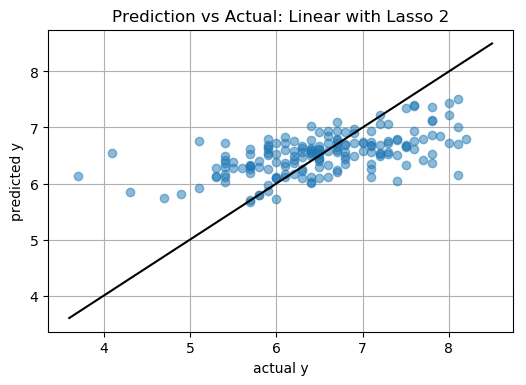

In [176]:
plt.figure(dpi=100)
plot_with_predict(df_train_s[var_list_cut], y_train, lasso_grid_2.best_estimator_)
plt.plot([3.6,8.5],[3.6,8.5],'k')
plt.title('Prediction vs Actual: Linear with Lasso 2');

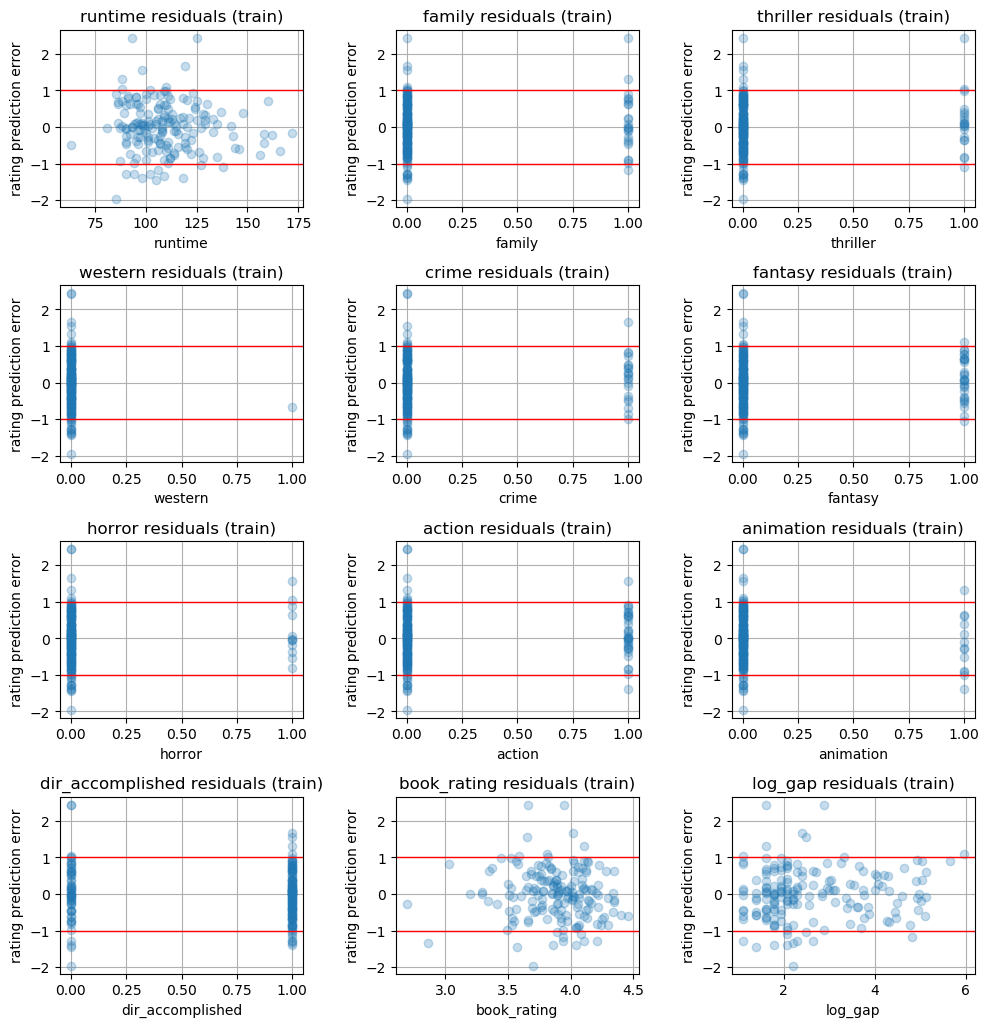

In [177]:
var_to_check = var_list_cut2

y_predict = lasso_grid_2.best_estimator_.predict(df_train_s[var_list_cut])
plot_residuals(df_train,y_predict,y_train,var_to_check)

In [178]:
# ridge with linear, round 2 just for shiggles
ridge_model_2 = Ridge(max_iter=5000)
parameters = {'alpha':[0.1, 1, 10, 50, 100, 150], 'fit_intercept':[True]}
ridge_grid_2 = GridSearchCV(ridge_model_2, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
ridge_grid_2.fit(df_train_s[var_list_cut], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 10, 50, 100, 150], 'fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [179]:
ridge_grid_2.cv_results_

{'mean_fit_time': array([0.00330858, 0.00220571, 0.00411086, 0.0021059 , 0.00160441,
        0.00210581]),
 'mean_score_time': array([0.00050125, 0.00060158, 0.00040116, 0.00030117, 0.00030069,
        0.00040102]),
 'mean_test_score': array([-0.61537983, -0.61269662, -0.59949931, -0.5860234 , -0.59059571,
        -0.59698213]),
 'mean_train_score': array([-0.48791088, -0.48726505, -0.48840027, -0.50771131, -0.52771034,
        -0.54411381]),
 'param_alpha': masked_array(data=[0.1, 1, 10, 50, 100, 150],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, True, True, True, True, True],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1, 'fit_intercept': True},
  {'alpha': 1, 'fit_intercept': True},
  {'alpha': 10, 'fit_intercept': True},
  {'alpha': 50, 'fit_intercept': True},
  {'alpha':

In [180]:
ridge_grid_2.best_estimator_.coef_

array([ 0.22406602, -0.13182613,  0.02212238, -0.07642031, -0.04092244,
        0.04005152, -0.02648703, -0.08815576,  0.02715804, -0.01983547,
       -0.06015769, -0.05761811, -0.09703753, -0.02899834, -0.10232794,
       -0.00432902,  0.11364229, -0.0358656 ,  0.06447529, -0.01287549,
       -0.01200336,  0.15858145,  0.05188743, -0.05802963])

In [181]:
# MAE and RMSE are lower than linear with lasso after the first cut, but not as good as the initial OLS or first linear with lasso
predictions = ridge_grid_2.best_estimator_.predict(df_train_s[var_list_cut])
rmse = np.sqrt(np.mean((predictions - y_train.values)**2))
mae = np.mean(abs(predictions - y_train.values))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.51
RMSE = 0.67


At this point, based on the MAE and RMSE scores, it seems the best model so far is still linear with lasso. This is the model that will be run on the test data to make some predictions

In [182]:
Xy_test_s = np.concatenate((X_test_s, y_test.values.reshape(-1,1)), axis=1)
df_test_s = pd.DataFrame(Xy_test_s, columns=X_test.columns.tolist() + ['user_rating'])

model_to_use = lasso_grid.best_estimator_
y_test_predict = model_to_use.predict(df_test_s[var_list])
y_test_predict

array([6.9045914 , 5.50401084, 6.4534063 , 5.97997817, 6.53770151,
       6.37832787, 7.1131924 , 6.42935201, 7.38213804, 7.29109137,
       6.36398878, 7.88094536, 5.56799505, 6.36506998, 6.3186541 ,
       6.56736181, 6.52752307, 6.63302553, 6.21846251, 6.03885905,
       6.32075777, 6.52081596, 6.6209856 , 6.27269048, 6.67510231,
       5.95526597, 6.37730205, 6.68435508, 6.6287828 , 6.44966972,
       5.52665539, 6.47475672, 5.70900752, 6.44964193, 7.25642242,
       6.05162814, 6.09478765, 7.19051857, 6.12786711, 7.41071748,
       6.55776593, 7.50212495, 6.58757941, 6.94172322])

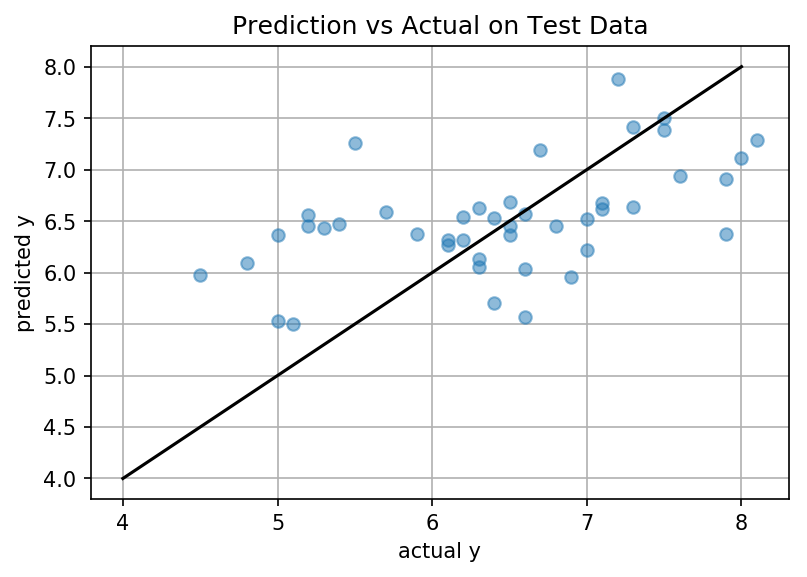

In [183]:
plt.figure(dpi=150)
plot_with_predict(df_test_s[var_list], y_test, model_to_use)
plt.plot([4, 8], [4, 8],'k')
plt.title('Prediction vs Actual on Test Data');

Text(0.5,1,'Residuals on Test Data')

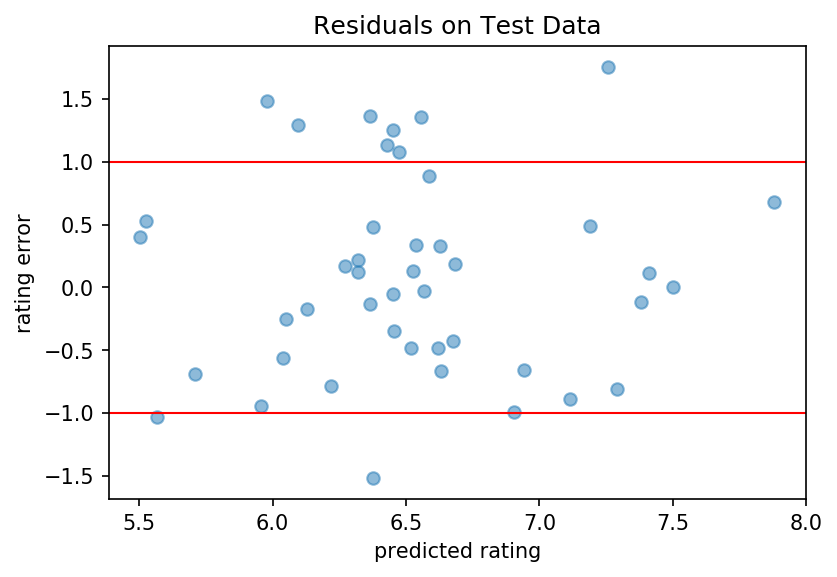

In [195]:
plt.figure(dpi=150)
plt.plot(y_test_predict,y_test_predict-y_test,'o', alpha=0.5)
plt.axhline(+1,color='r',lw=1,ls='-')
plt.axhline(-1,color='r',lw=1,ls='-')
plt.xlabel('predicted rating')
plt.ylabel('rating error')
plt.title('Residuals on Test Data')

This model ends up predicting outside the +/- 1 range 9 times out of 44 which is.. not great. However, 8 of those are over-predictions which result in ratings below 6.6. Only 1 was over-predicted resulting in a rating above 7.0. Since I am interested in which films are "good" and worth seeing (with ratings 7+), this model is sufficient in preventing me from seeing the majority of "bad" films.

In [289]:
predictions = lasso_grid.best_estimator_.predict(df_test_s[var_list])
rmse = np.sqrt(np.mean((predictions - y_test.values)**2))
mae = np.mean(abs(predictions - y_test.values))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.63
RMSE = 0.78


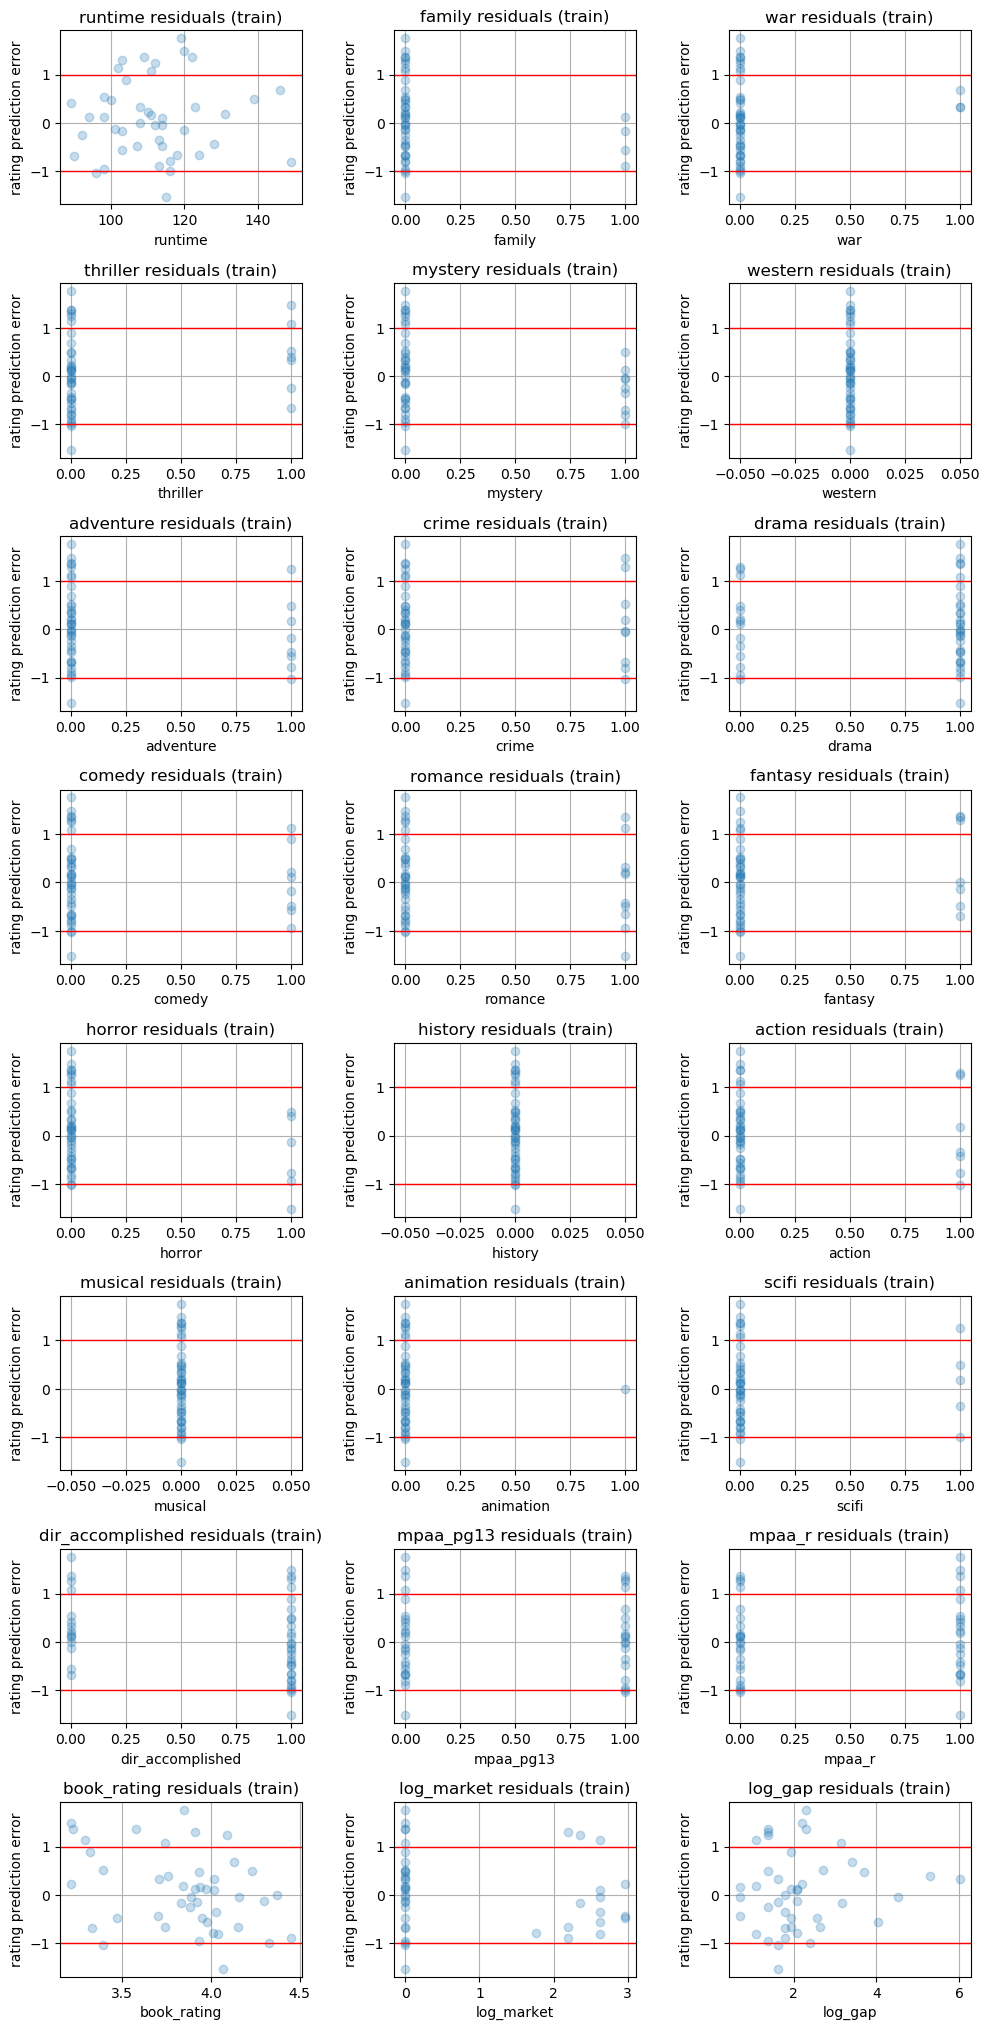

In [106]:
var_to_check = var_list_cut

y_predict = model_to_use.predict(df_test_s[var_list])
plot_residuals(X_test,y_predict,y_test,var_to_check)

In [193]:
# create dataframe within which to CHECK for outliers outside the +/- 1 tolerance
df_check_outliers4 = df_test[df_test.columns[:-5]].copy()
df_check_outliers4['error'] = round((model_to_use.predict(df_test_s[var_list]) - y_test),1)
df_check_outliers4['actual'] = y_test
df_check_outliers4['predict'] = np.round(model_to_use.predict(df_test_s[var_list]),1)
df_check_outliers4[abs(df_check_outliers4['error'])>1].sort_values(by=['error'],ascending=False)

,runtime,avg_dir_gross,family,war,thriller,mystery,western,adventure,crime,drama,...,market_share,mpaa_pg,mpaa_pg13,mpaa_r,book_rating,reviewers,year_gap,error,actual,predict
34,119.0,0.000000e+00,False,False,False,False,False,False,False,True,...,0.0,0,0,1,3.85,2115,9,1.8,5.5,7.3
3,120.0,8.726333e+05,False,False,True,False,False,False,True,True,...,0.0,0,0,1,3.21,107278,8,1.5,4.5,6.0
13,109.0,0.000000e+00,False,False,False,False,False,False,False,True,...,0.0,0,0,1,3.22,13076,9,1.4,5.0,6.4
40,122.0,5.225551e+07,False,False,False,False,False,False,False,True,...,0.0,0,1,0,3.58,4145221,3,1.4,5.2,6.6
36,103.0,4.902620e+07,False,False,False,False,False,False,True,False,...,8.0,0,1,0,3.91,784,3,1.3,4.8,6.1
33,112.0,0.000000e+00,False,False,False,False,False,True,False,False,...,9.6,0,1,0,4.09,319074,3,1.2,5.2,6.4
7,102.0,2.150139e+08,False,False,False,False,False,False,False,False,...,12.9,0,1,0,3.29,6989,2,1.1,5.3,6.4
31,111.0,0.000000e+00,False,False,True,False,False,False,False,True,...,0.0,0,0,1,3.74,14557,22,1.1,5.4,6.5
5,115.0,1.535135e+07,False,False,False,False,False,False,False,True,...,0.0,0,0,1,4.07,71336,4,-1.5,7.9,6.4


In [194]:
for i in df_check_outliers4[abs(df_check_outliers4['error'])>1]['reviewers']:
    print(df_bookdata[df_bookdata['reviewers']==i]['title'].values, i)

['The Dinner'] 107278
['Let Me In' 'Let the Right One In'] 71336
['I Love You, Beth Cooper'] 6989
['Cosmopolis'] 13076
['The Garden of Eden'] 14557
['The 5th Wave'] 319074
['The World Made Straight'] 2115
['The Spirit'] 784
['Twilight'] 4145221


In [202]:
df_test[var_list].columns

Index(['runtime', 'family', 'war', 'thriller', 'mystery', 'western',
       'adventure', 'crime', 'drama', 'comedy', 'romance', 'fantasy', 'horror',
       'history', 'action', 'musical', 'animation', 'scifi',
       'dir_accomplished', 'mpaa_pg', 'mpaa_pg13', 'mpaa_r', 'book_rating',
       'log_gross', 'log_market', 'log_reviewers', 'log_gap'],
      dtype='object')

In [200]:
model_to_use.coef_

array([ 0.31861659, -0.28419445, -0.01290247, -0.16896846, -0.1331943 ,
        0.03538566, -0.12964215, -0.17248113, -0.08437872, -0.10423401,
       -0.21740773, -0.12277906, -0.16892114, -0.08351467, -0.21712241,
       -0.03903546,  0.10894988, -0.08677631,  0.06907677,  0.        ,
       -0.0665148 , -0.06698861,  0.17392012,  0.        ,  0.05554528,
       -0.        , -0.06414817])

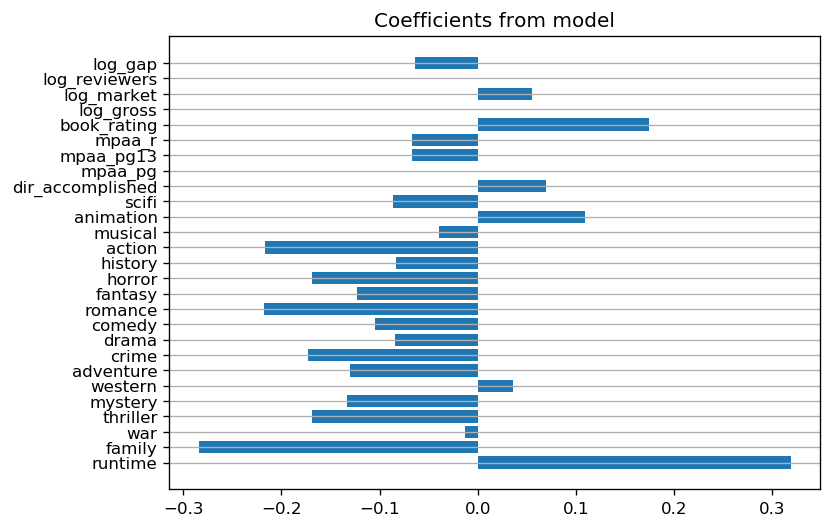

In [227]:
plt.figure(figsize=(7,5),dpi=120)
plt.grid(axis='y')
values = model_to_use.coef_.tolist()
varnames = df_test[var_list].columns.tolist()
plt.barh(np.arange(len(varnames)),values)
plt.yticks(np.arange(len(varnames)),varnames)
plt.title('Coefficients from model');

The graph above shows the beta coefficients that were determined by the model. The highest positive effect came from runtime, followed by book rating. This is interesting because it suggests that the longer a movie, the more likely it will have a higher rating. On the negative side, family, romance, and action had the greatest effect on film rating. 

Text(0.5,1,'Residuals on Test Data')

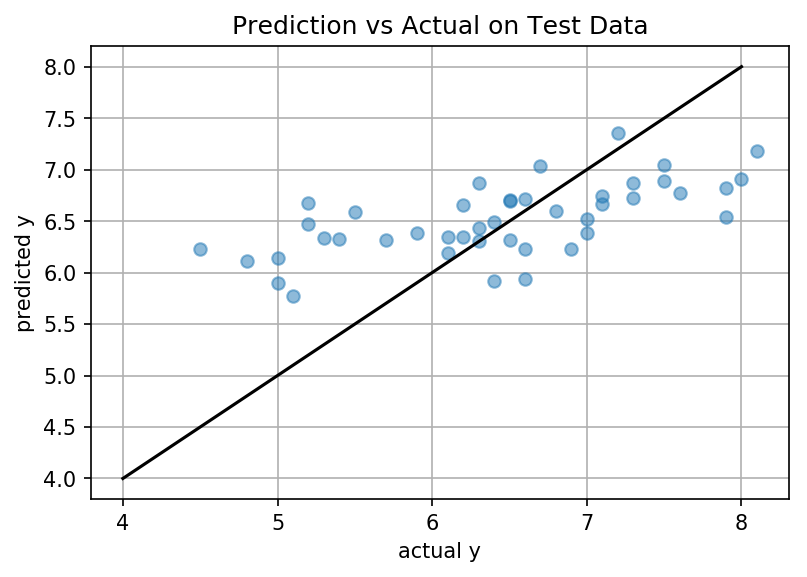

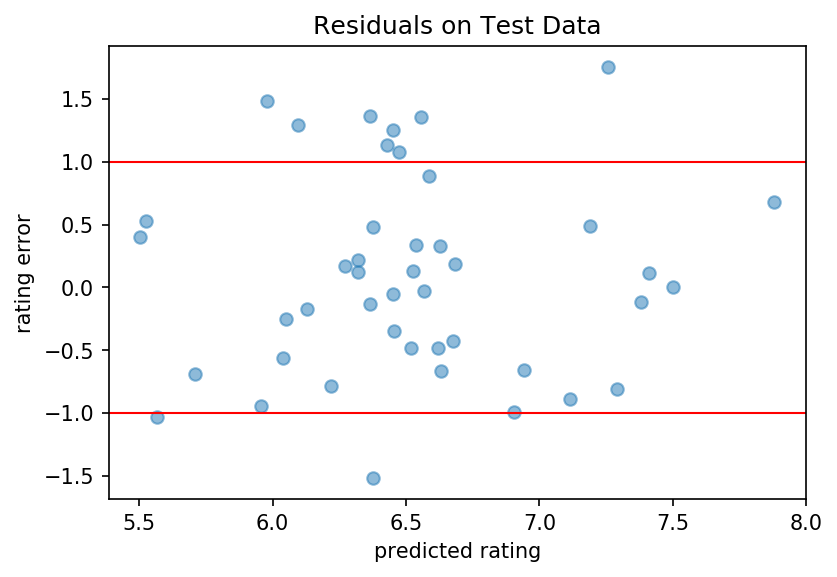

In [285]:
# What if I had chosen Ridge, which had higher MAE and RMSE but less overfitting?

plt.figure(dpi=150)
plot_with_predict(df_test_s[var_list], y_test, ridge_grid.best_estimator_)
plt.plot([4, 8], [4, 8],'k')
plt.title('Prediction vs Actual on Test Data');

plt.figure(dpi=150)
plt.plot(y_test_predict,y_test_predict-y_test,'o', alpha=0.5)
plt.axhline(+1,color='r',lw=1,ls='-')
plt.axhline(-1,color='r',lw=1,ls='-')
plt.xlabel('predicted rating')
plt.ylabel('rating error')
plt.title('Residuals on Test Data')

In [288]:
predictions = ridge_grid.best_estimator_.predict(df_test_s[var_list])
rmse = np.sqrt(np.mean((predictions - y_test.values)**2))
mae = np.mean(abs(predictions - y_test.values))
print('MAE = '+str(round(mae,2)))
print('RMSE = '+str(round(rmse,2)))

MAE = 0.62
RMSE = 0.75
